# Data Science Fundamentals Project

Welcome to our data science project focused on predicting NO2 concentrations. We are using advanced analytics and machine learning to forecast NO2 levels based on a range of features, from meteorological conditions to human activities. Our goal is to contribute to environmental sustainability by developing a precise predictive model.

In [2]:
# Load all of the necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
import re
import numpy as np
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

## Datasets
For our prediction, the following datasets are necessary:

- 1: Täglich aktualisierte Luftqualitätsmessungen, seit 1983
   - https://data.stadt-zuerich.ch/dataset/ugz_luftschadstoffmessung_tageswerte
- 2: Daten der Verkerzählung zum motorisierten Individualverkehr (Stundenwerte), seit 2012
   - https://data.stadt-zuerich.ch/dataset/sid_dav_verkehrszaehlung_miv_od2031
- 3: Täglich aktualisierte Meteodaten, seit 1992
   - https://data.stadt-zuerich.ch/dataset/ugz_meteodaten_tagesmittelwerte
- 4: Stündlich aktualisierte Meteodaten, seit 1992
   - https://data.stadt-zuerich.ch/dataset/ugz_meteodaten_stundenmittelwerte
- 5: Baumkataster
   - https://data.stadt-zuerich.ch/dataset/geo_baumkataster


We decided to make predictions on a daily basis, as to not be too granular with our prediction.

## Preprocessing
The first step was to merge all of the datasets to be able to predict NO2 well with the other columns. 

Dataset 1, that measures the airquality with different features, was also established by merging 12 datasets with numbers from 2012 to 2023.

Dataset 2, that counts the passing cars, was established by merging the 12 individual datasets that include the data from 2012 to 2023.

Dataset 3, <span style="color:red">[INSERT DESCRIPTION]</span>

Dataset 4, <span style="color:red">[INSERT DESCRIPTION]</span>

### Functions used for Preprocessing
- We created the function "import_and_transform_air_quality_data()" to loop over all of the years from 2012 to 2023 and merge all of the datasets while only taking into consideration the streets of interest, namely "Rosengartenstrasse", "Stampfenbachstrasse" and "Schimmelstrasse". We decided to only inspect these streets because <span style="color:red">[INSERT REASON]</span>

In [3]:
def import_and_transform_air_quality_data():
    streets = ['Zch_Rosengartenstrasse', 'Zch_Stampfenbachstrasse', 'Zch_Schimmelstrasse']
    street_dataframes = []

    for street in streets:
        yearly_data = []

        for year in range(2012, 2024):
            file_path = f'data/air/ugz_ogd_air_d1_{year}.csv'
            data = pd.read_csv(file_path)

            # Filter for a specific street
            street_data = data[data['Standort'] == street]

            # Pivot the data
            street_wide = street_data.pivot(index='Datum', columns='Parameter', values='Wert')

            # Add the year and street columns
            street_wide['Year'] = year
            street_wide['Street'] = street

            yearly_data.append(street_wide)

        # Concatenate all years' data for the street
        combined_street_data = pd.concat(yearly_data)
        street_dataframes.append(combined_street_data)

    # Concatenate all streets' data into one DataFrame
    combined_data = pd.concat(street_dataframes)

    return combined_data


The cell below saves the 12 airquality datasets into one big dataset

In [4]:
airquality = import_and_transform_air_quality_data()

- Another function we created is "import_and_transform_traffic_data()", which handles the preprocessing for datset 2 in a similar fashion as the function above.

In [69]:
def import_and_transform_traffic_data():
    streets = ['Stampfenbachstrasse (Wasserwerkstrasse)', 'Schimmelstrasse (Werdstrasse)', 'Rosengartenstrasse']
    street_dataframes = []

    for street in streets:
        yearly_data = []

        for year in range(2012, 2024):
            file_path = f'data/traffic/sid_dav_verkehrszaehlung_miv_OD2031_{year}.csv'
            traffic = pd.read_csv(file_path, low_memory=False)


            # Drop unnecessary columns and filter for a specific street
            traffic_small = traffic.drop(columns=['MSID', 'MSName', 'Hoehe', 'EKoord', 'NKoord', 'AnzDetektoren', 'D1ID', 'D2ID', 'D3ID','D4ID', 'Knummer', 'ZSID'])
            traffic_rg = traffic_small[traffic_small['ZSName'] == street].copy()

            # Convert 'MessungDatZeit' column to datetime
            try:
                traffic_rg['MessungDatZeit'] = pd.to_datetime(traffic_rg['MessungDatZeit'])
            except pd.errors.OutOfBoundsDatetime:
                # Handle conversion errors, for example, if the data contains unexpected values
                print(f"Error converting 'MessungDatZeit' column for year {year} and street {street}")

            # Aggregate data
            daily_traffic = traffic_rg.groupby(traffic_rg['MessungDatZeit'].dt.date)['AnzFahrzeuge'].sum().reset_index(name='TotalDailyTraffic')
            daily_traffic['Year'] = year
            daily_traffic['Street'] = street

            yearly_data.append(daily_traffic)

        # Concatenate all years' data for the street
        combined_street_data = pd.concat(yearly_data)
        street_dataframes.append(combined_street_data)

    # Concatenate all streets' data into one DataFrame
    combined_data = pd.concat(street_dataframes)

    return combined_data

The cell below saves the 12 traffic datasets into one big dataset

In [70]:
traffic = import_and_transform_traffic_data()

Now, we have two big datasets with all of the relevant data from years 2012 to 2023. To be able to merge them we do the steps in the cell below.

In [72]:
#Introduce an Index for both df
airquality = airquality.reset_index()
traffic = traffic.reset_index()
# Convert the 'Datum' column in air quality data to datetime and extract the date
airquality['Datum'] = pd.to_datetime(airquality['Datum']).dt.date

# Replace street names in traffic data to match the air quality data
traffic.replace(['Stampfenbachstrasse (Wasserwerkstrasse)', 'Schimmelstrasse (Werdstrasse)', 'Rosengartenstrasse'],
                ['Zch_Stampfenbachstrasse', 'Zch_Schimmelstrasse', 'Zch_Rosengartenstrasse'], inplace=True)

# Rename the 'MessungDatZeit' column in traffic data to 'Datum'
traffic.rename(columns={'MessungDatZeit': 'Datum'}, inplace=True)

#### Merging of the two datasets

In [8]:
merged_df = pd.merge(traffic, airquality, how="left", on=['Datum', 'Street'])
merged_df.drop(columns=['Year_x', 'Year_y'], inplace=True)

### Additional Features: Meteo Data
Now that we have many of the necessary features inside of one dataset, we want to add some more that could make our prediction model more accurate. For that we turned to meteo data, which is dataset 3.






In [9]:
def import_and_transform_meteo_data():
    streets = ['Zch_Rosengartenstrasse', 'Zch_Stampfenbachstrasse', 'Zch_Schimmelstrasse']
    street_dataframes = []

    for street in streets:
        yearly_data = []

        for year in range(2012, 2024):
            file_path = f'data/meteo/daily/ugz_ogd_meteo_d1_{year}.csv'
            data = pd.read_csv(file_path)

            # Filter for a specific street
            street_data = data[data['Standort'] == street]

            # Pivot the data and reset the index
            street_wide = street_data.pivot(index='Datum', columns='Parameter', values='Wert').reset_index()

            # Add the year and street columns
            street_wide['Year'] = year
            street_wide['Street'] = street

            yearly_data.append(street_wide)

        # Concatenate all years' data for the street
        combined_street_data = pd.concat(yearly_data)
        street_dataframes.append(combined_street_data)

    # Concatenate all streets' data into one DataFrame
    combined_data = pd.concat(street_dataframes)

    return combined_data


In [10]:
meteo = import_and_transform_meteo_data()
meteo['Datum'] = pd.to_datetime(meteo['Datum']).dt.date
meteo.head()

Parameter       Datum  Year                  Street  RainDur   T  T_max_h1  \
0          2013-10-04  2013  Zch_Rosengartenstrasse   191.77 NaN       NaN   
1          2013-10-05  2013  Zch_Rosengartenstrasse    84.13 NaN       NaN   
2          2013-10-06  2013  Zch_Rosengartenstrasse   147.52 NaN       NaN   
3          2013-10-07  2013  Zch_Rosengartenstrasse     0.00 NaN       NaN   
4          2013-10-08  2013  Zch_Rosengartenstrasse     0.00 NaN       NaN   

Parameter       p  StrGlo  
0          969.68     NaN  
1          968.27     NaN  
2          973.08     NaN  
3          973.86     NaN  
4          973.71     NaN

The cell below merges the merged dataframe and the meteo dataframe.

In [11]:
# Merge DataFrames
merged_meteo = pd.merge(merged_df, meteo, how="left", on=['Datum', 'Street'])

windspeed and humidity data is only found in the hourly meteo set, so we will sum it up to daily values and add it 

In [12]:
def import_and_transform_meteo_hourly_data():
    streets = ['Zch_Rosengartenstrasse', 'Zch_Stampfenbachstrasse', 'Zch_Schimmelstrasse']
    street_dataframes = []
    parameters = ['WD', 'WVv', 'WVs', 'Hr']

    for year in range(2012, 2024): 
        for street in streets:
            file_path = f'data/meteo/hourly/ugz_ogd_meteo_h1_{year}.csv'  
            data = pd.read_csv(file_path)

            # Filter for a specific street
            street_data = data[data['Standort'] == street]

            # Pivot the data to wide format
            street_wide = street_data.pivot(index='Datum', columns='Parameter', values='Wert')

            # Reset index to make 'Datum' a column again
            street_wide.reset_index(inplace=True)

            # Convert 'Datum' to datetime and keep only the date part
            street_wide['Datum'] = pd.to_datetime(street_wide['Datum']).dt.date

            # Select only the columns that exist in the dataset
            cols_to_keep = ['Datum'] + [col for col in parameters if col in street_wide.columns]
            street_wide = street_wide[cols_to_keep]

            # Group by Datum, calculate daily mean
            daily_mean = street_wide.groupby('Datum', as_index=False).mean()

            # Add the street name to the DataFrame
            daily_mean['Street'] = street

            street_dataframes.append(daily_mean)

    # Concatenate all streets' data into one DataFrame
    combined_data = pd.concat(street_dataframes, ignore_index=True)

    return combined_data

# Use this function and export the result if needed
meteo_hourly = import_and_transform_meteo_hourly_data()
#merge it

merged_meteo = pd.merge(merged_meteo, meteo_hourly, how="left", on=['Datum', 'Street'])

### Additional Features: Dummies

Dummies enable the model to consider seasonal and weekday variations, potentially improving predictions by capturing temporal patterns in the target variable.


In [13]:
# Convert 'Datum' to datetime
merged_meteo['Datum'] = pd.to_datetime(merged_meteo['Datum'])

# Drop unnecessary columns
merged_meteo.drop(columns=['Year'], inplace=True)

# Adding season dummies
#def get_month(date):
   # month_dict = {
        #1: 'Jan',
        #2: 'Feb',
        #3: 'Mar',
        #4: 'Apr',
       # 5: 'May',
       # 6: 'Jun',
       # 7: 'Jul',
       # 8: 'Aug',
       # 9: 'Sep',
       # 10: 'Oct',
       # 11: 'Nov',
       # 12: 'Dec'
   # }
    #return month_dict[date.month]

#merged_meteo['Month'] = merged_meteo['Datum'].apply(get_month)
#month_dummies = pd.get_dummies(merged_meteo['Month'])
#merged_meteo = pd.concat([merged_meteo, month_dummies], axis=1).drop(columns=['Month'])

merged_meteo['Season'] = (merged_meteo['Datum'].dt.month % 12 + 3) // 3
season_dummies = pd.get_dummies(merged_meteo['Season'], prefix='Season')
merged_meteo = pd.concat([merged_meteo, season_dummies], axis=1).drop(columns=['Season'])

# Adding weekday dummies
merged_meteo['Weekday'] = merged_meteo['Datum'].dt.dayofweek
weekday_dummies = pd.get_dummies(merged_meteo['Weekday'], prefix='Weekday')
merged_meteo = pd.concat([merged_meteo, weekday_dummies], axis=1)
merged_meteo.drop(['Weekday'], axis=1, inplace=True)

### Additional Features: Relevant Street Specific Data

As we want to generalize our model to be applicable to other streets, we tried to find data which is relevant for the specific street.

The only data we found: Data on Trees and Greenspaces (coordinates).

We used this to calculate the trees/greenspaces around our measurement points

In [14]:
#calculating trees around measurement points

tree_locations_df = pd.read_csv('data/street/gsz.baumkataster_baumstandorte.csv')

def extract_coordinates(point_str):
    numbers = re.findall(r"[-+]?\d*\.\d+|\d+", point_str)
    return tuple(map(float, numbers))

tree_locations_df['coordinates'] = tree_locations_df['geometry'].apply(extract_coordinates)

def calculate_distance(coord1, coord2):
    return ((coord1[0] - coord2[0]) ** 2 + (coord1[1] - coord2[1]) ** 2) ** 0.5

target_coords = {
    "Zch_Rosengartenstrasse": (2682095, 1249940),
    "Zch_Schimmelstrasse": (2681950, 1247250),
    "Zch_Stampfenbachstrasse": (2683140, 1249040)
}

tree_counts_df = pd.DataFrame(columns=['Street', '1.5km', '1km', '500m', '200m'])

for street, coords in target_coords.items():
    tree_counts = {
        'Street': street,
        '1.5km': sum(calculate_distance(tree_coord, coords) <= 1500 for tree_coord in tree_locations_df['coordinates']),
        '1km': sum(calculate_distance(tree_coord, coords) <= 1000 for tree_coord in tree_locations_df['coordinates']),
        '500m': sum(calculate_distance(tree_coord, coords) <= 500 for tree_coord in tree_locations_df['coordinates']),
        '200m': sum(calculate_distance(tree_coord, coords) <= 200 for tree_coord in tree_locations_df['coordinates'])
    }
    tree_counts_df = pd.concat([tree_counts_df, pd.DataFrame([tree_counts])], ignore_index=True)


# calculating green spaces around measurement points

green_spaces_df = pd.read_csv('data/street/gsz.gruenflaechen.csv')

green_spaces_df['coordinates'] = green_spaces_df['geometry'].apply(extract_coordinates)

green_space_counts_df = pd.DataFrame(columns=['Street', '1.5km', '1km', '500m', '200m'])

for street, coords in target_coords.items():
    green_space_counts = {
        'Street': street,
        '1.5km': sum(calculate_distance(green_coord, coords) <= 1500 for green_coord in green_spaces_df['coordinates']),
        '1km': sum(calculate_distance(green_coord, coords) <= 1000 for green_coord in green_spaces_df['coordinates']),
        '500m': sum(calculate_distance(green_coord, coords) <= 500 for green_coord in green_spaces_df['coordinates']),
        '200m': sum(calculate_distance(green_coord, coords) <= 200 for green_coord in green_spaces_df['coordinates'])
    }
    green_space_counts_df = pd.concat([green_space_counts_df, pd.DataFrame([green_space_counts])], ignore_index=True)


In [15]:
#merging it with the data set

merged_meteo = pd.merge(merged_meteo, green_space_counts_df, on='Street', how='left', suffixes=('_green', ''))
merged_meteo = pd.merge(merged_meteo, tree_counts_df, on='Street', how='left', suffixes=('','_trees'))
distance_columns_to_rename = {
    '1.5km': '1.5km_green',
    '1km': '1km_green',
    '500m': '500m_green',
    '200m': '200m_green'
}
merged_meteo = merged_meteo.rename(columns=distance_columns_to_rename)
merged_meteo.columns

Index(['index', 'Datum', 'TotalDailyTraffic', 'Street', 'NO', 'NO2', 'NOx',
       'O3', 'O3_max_h1', 'O3_nb_h1>120', 'PM10', 'PM2.5', 'CO', 'SO2', 'PN',
       'RainDur', 'T', 'T_max_h1', 'p', 'StrGlo', 'WD', 'WVv', 'WVs', 'Hr',
       'Season_1', 'Season_2', 'Season_3', 'Season_4', 'Weekday_0',
       'Weekday_1', 'Weekday_2', 'Weekday_3', 'Weekday_4', 'Weekday_5',
       'Weekday_6', '1.5km_green', '1km_green', '500m_green', '200m_green',
       '1.5km_trees', '1km_trees', '500m_trees', '200m_trees'],
      dtype='object')

### Target Variable NO2_tomorrow

For our model we want to predict future values. Thus, our target variable is the NO2 value of tomorrow. For this we shift up the NO2 column by one row, which allows us to use past information to predict the next day's NO2 level. We do this for each street seperately and then merge them together.

In [16]:
# Create the NO2_tomorrow (target variable) column by shifting the NO2 column up by one row
unique_streets = merged_meteo['Street'].unique()
data_separated = []
for street in unique_streets:
    df_street = merged_meteo[merged_meteo['Street'] == street].copy()
    df_street['NO2_tomorrow'] = df_street['NO2'].shift(-1)
    data_separated.append(df_street)

merged_meteo = pd.concat(data_separated)

merged_meteo


index      Datum  TotalDailyTraffic                   Street     NO  \
0          0 2012-01-01             8118.0  Zch_Stampfenbachstrasse   7.83   
1          1 2012-01-02             7537.0  Zch_Stampfenbachstrasse   3.51   
2          2 2012-01-03            11722.0  Zch_Stampfenbachstrasse   5.85   
3          3 2012-01-04            12161.0  Zch_Stampfenbachstrasse   2.59   
4          4 2012-01-05            12310.0  Zch_Stampfenbachstrasse   2.23   
...      ...        ...                ...                      ...    ...   
13024    324 2023-11-21            24188.0   Zch_Rosengartenstrasse  23.29   
13025    325 2023-11-22            25017.0   Zch_Rosengartenstrasse  19.41   
13026    326 2023-11-23            24714.0   Zch_Rosengartenstrasse  30.60   
13027    327 2023-11-24            25337.0   Zch_Rosengartenstrasse  22.50   
13028    328 2023-11-25            22228.0   Zch_Rosengartenstrasse  15.81   

         NO2    NOx     O3  O3_max_h1  O3_nb_h1>120  ...  Weekday_6  \
0      26.54  20.16  22.24      43.46           0.0  ...       True   
1      17.87  12.16  36.06      53.56           0.0  ...      False   
2      19.62  14.95  48.88      66.05           0.0  ...      False   
3      13.25   9.00  59.47      67.55           0.0  ...      False   
4      10.11   7.08  62.58      71.45           0.0  ...      False   
...      ...    ...    ...        ...           ...  ...        ...   
13024  35.09  37.02  27.96      57.38           0.0  ...      False   
13025  22.47  27.31  23.17      33.90           0.0  ...      False   
13026  30.86  40.67  10.30      21.01           0.0  ...      False   
13027  29.74  33.59  33.94      54.68           0.0  ...      False   
13028  24.91  25.70  39.99      51.06           0.0  ...      False   

       1.5km_green  1km_green  500m_green  200m_green  1.5km_trees  1km_trees  \
0             7471       4473        1611         132         9115       4054   
1             7471       4473        1611         132         9115       4054   
2             7471       4473        1611         132         9115       4054   
3             7471       4473        1611         132         9115       4054   
4             7471       4473        1611         132         9115       4054   
...            ...        ...         ...         ...          ...        ...   
13024         8289       3424        1271         219         9730       3376   
13025         8289       3424        1271         219         9730       3376   
13026         8289       3424        1271         219         9730       3376   
13027         8289       3424        1271         219         9730       3376   
13028         8289       3424        1271         219         9730       3376   

       500m_trees  200m_trees  NO2_tomorrow  
0            1419         152         17.87  
1            1419         152         19.62  
2            1419         152         13.25  
3            1419         152         10.11  
4            1419         152         17.67  
...           ...         ...           ...  
13024         918         179         22.47  
13025         918         179         30.86  
13026         918         179         29.74  
13027         918         179         24.91  
13028         918         179           NaN  

[13029 rows x 44 columns]

### Addressing Seasonality in the Data

While we've incorporated dummy variables for both season and weekday, it's worth considering the impact of seasonality on our observations. Let's explore the dataset to better understand the presence of seasonality and assess whether its removal could enhance our analysis.

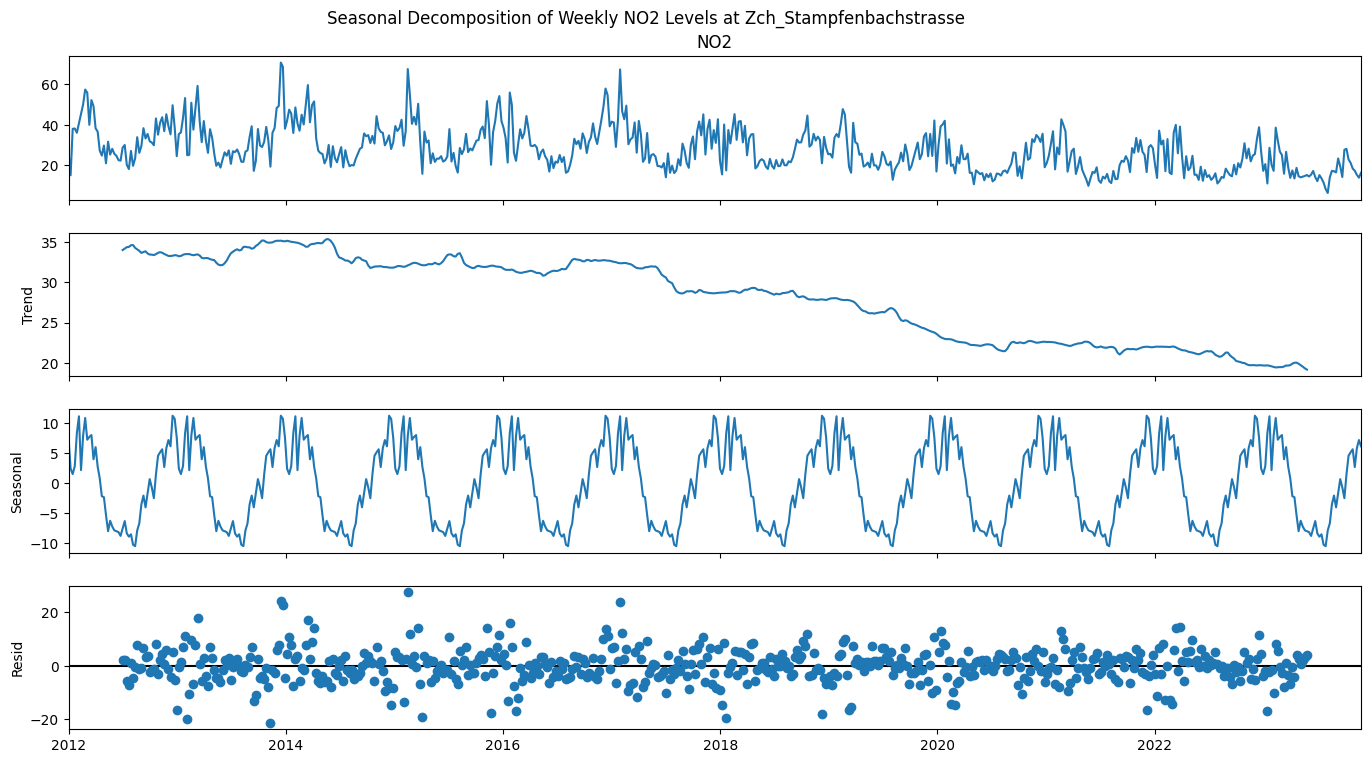

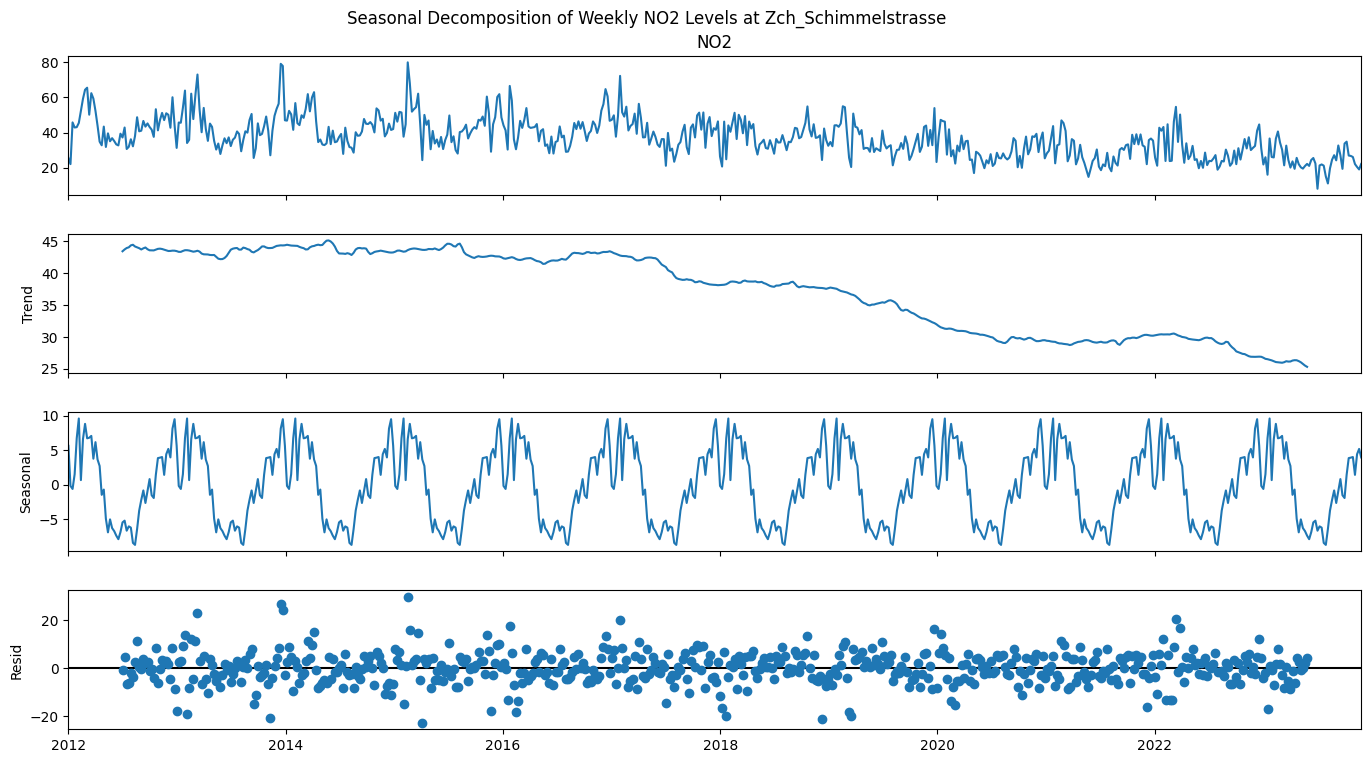

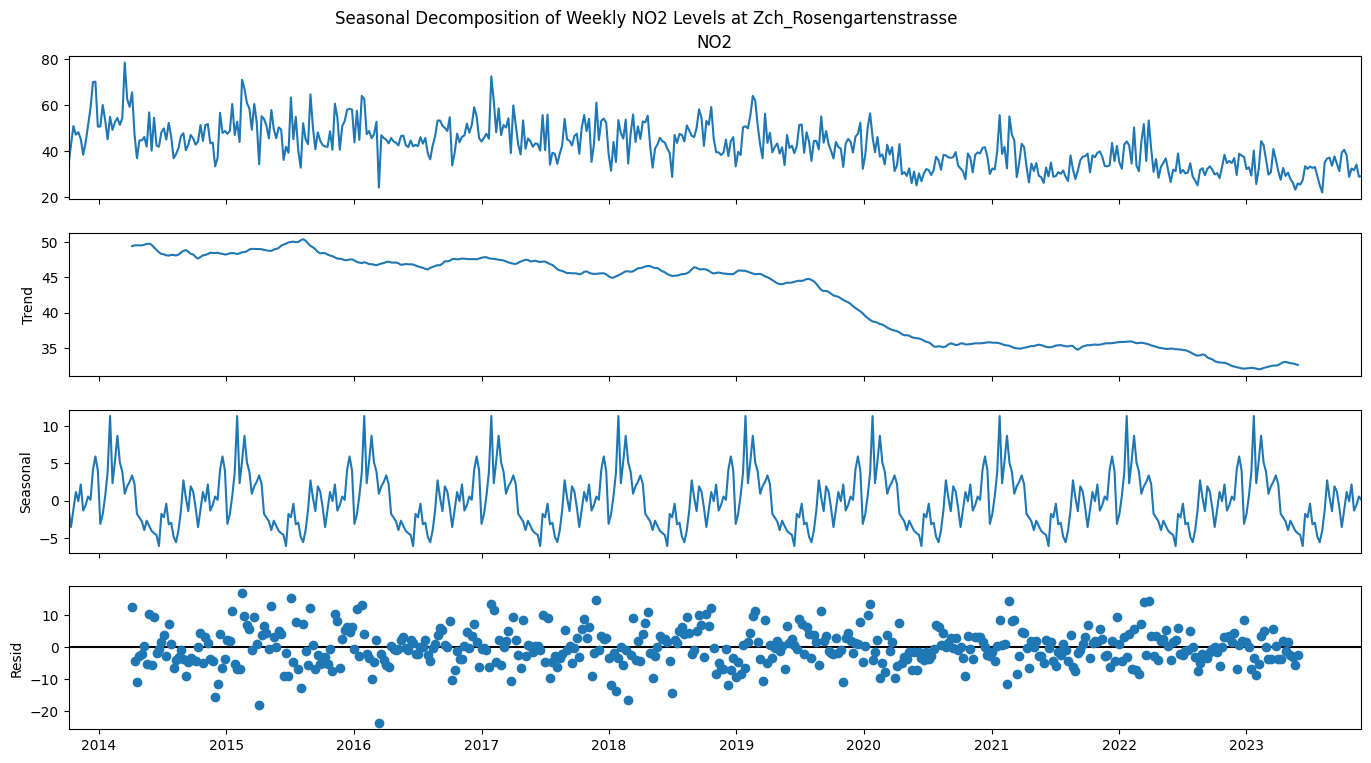

In [17]:
unique_streets = merged_meteo['Street'].unique()

# Iterating through each street and performing seasonal decomposition
for street in unique_streets:
    # Filtering data for the current street
    street_data = merged_meteo[merged_meteo['Street'] == street]

    # Aggregating NO2 levels to weekly average
    street_data.set_index('Datum', inplace=True)
    weekly_street_data = street_data['NO2'].resample('W').mean()

    # Perform seasonal decomposition if there are enough data points
    if not weekly_street_data.isnull().all():
        decomposition = seasonal_decompose(weekly_street_data.dropna(), model='additive', period=52)

        # Plotting the decomposed components of the time series
        fig = decomposition.plot()
        fig.set_size_inches(15, 8)
        plt.suptitle(f'Seasonal Decomposition of Weekly NO2 Levels at {street}')
        plt.show()
    else:
        print(f"No NO2 values are available for {street} in the dataset.")


In our analysis, we have observed pronounced seasonality across all three streets in the dataset. Notably, the incorporation of NO2 as a feature, with a time lag of only one day (`NO2_tomorrow`), inherently captures the observed seasonality. The temporal dependencies in NO2, including both short-term fluctuations and seasonal patterns, are implicitly accounted for in our model.

Additionally, we have identified a discernible downward trend in our target variable. This trend is also integrated into our NO2 feature through its time-lagged representation. By leveraging the sequential nature of time series data, our model is designed to not only capture seasonality but also naturally incorporate trends, providing a comprehensive representation of historical patterns.

These considerations affirm our approach to feature engineering and the effectiveness of our model in accounting for both short-term and long-term temporal dynamics in NO2 levels.


### Splitting Training and Test Set

We want to use the 2023 data as a test set for our model. However, for imputing, we use the same tactics for both train and test set

In [18]:
merged_meteo.head()

index      Datum  TotalDailyTraffic                   Street    NO    NO2  \
0      0 2012-01-01             8118.0  Zch_Stampfenbachstrasse  7.83  26.54   
1      1 2012-01-02             7537.0  Zch_Stampfenbachstrasse  3.51  17.87   
2      2 2012-01-03            11722.0  Zch_Stampfenbachstrasse  5.85  19.62   
3      3 2012-01-04            12161.0  Zch_Stampfenbachstrasse  2.59  13.25   
4      4 2012-01-05            12310.0  Zch_Stampfenbachstrasse  2.23  10.11   

     NOx     O3  O3_max_h1  O3_nb_h1>120  ...  Weekday_6  1.5km_green  \
0  20.16  22.24      43.46           0.0  ...       True         7471   
1  12.16  36.06      53.56           0.0  ...      False         7471   
2  14.95  48.88      66.05           0.0  ...      False         7471   
3   9.00  59.47      67.55           0.0  ...      False         7471   
4   7.08  62.58      71.45           0.0  ...      False         7471   

   1km_green  500m_green  200m_green  1.5km_trees  1km_trees  500m_trees  \
0       4473        1611         132         9115       4054        1419   
1       4473        1611         132         9115       4054        1419   
2       4473        1611         132         9115       4054        1419   
3       4473        1611         132         9115       4054        1419   
4       4473        1611         132         9115       4054        1419   

   200m_trees  NO2_tomorrow  
0         152         17.87  
1         152         19.62  
2         152         13.25  
3         152         10.11  
4         152         17.67  

[5 rows x 44 columns]

In [19]:
# Drop the redundant index column
merged_meteo.drop(columns=['index'], inplace=True)

In [20]:
# Filtering the dataset for the test set (year 2023)
test_set = merged_meteo[merged_meteo['Datum'].dt.year == 2023]

# Filtering the dataset for the train set (years other than 2023)
train_set = merged_meteo[merged_meteo['Datum'].dt.year != 2023]

train_set.head()

Datum  TotalDailyTraffic                   Street    NO    NO2    NOx  \
0 2012-01-01             8118.0  Zch_Stampfenbachstrasse  7.83  26.54  20.16   
1 2012-01-02             7537.0  Zch_Stampfenbachstrasse  3.51  17.87  12.16   
2 2012-01-03            11722.0  Zch_Stampfenbachstrasse  5.85  19.62  14.95   
3 2012-01-04            12161.0  Zch_Stampfenbachstrasse  2.59  13.25   9.00   
4 2012-01-05            12310.0  Zch_Stampfenbachstrasse  2.23  10.11   7.08   

      O3  O3_max_h1  O3_nb_h1>120   PM10  ...  Weekday_6  1.5km_green  \
0  22.24      43.46           0.0  18.04  ...       True         7471   
1  36.06      53.56           0.0   5.34  ...      False         7471   
2  48.88      66.05           0.0   6.92  ...      False         7471   
3  59.47      67.55           0.0   7.49  ...      False         7471   
4  62.58      71.45           0.0   4.92  ...      False         7471   

   1km_green  500m_green  200m_green  1.5km_trees  1km_trees  500m_trees  \
0       4473        1611         132         9115       4054        1419   
1       4473        1611         132         9115       4054        1419   
2       4473        1611         132         9115       4054        1419   
3       4473        1611         132         9115       4054        1419   
4       4473        1611         132         9115       4054        1419   

   200m_trees  NO2_tomorrow  
0         152         17.87  
1         152         19.62  
2         152         13.25  
3         152         10.11  
4         152         17.67  

[5 rows x 43 columns]

#### (Train Set) --> imputing both

In [21]:
# Checking for missing values in the target variable 'NO2_tomorrow'

missing_values_target = train_set['NO2_tomorrow'].isnull().sum() #revealed around 700 missing values, we will delete these rows
train_set = train_set.dropna(subset=['NO2_tomorrow'])
test_set = test_set.dropna(subset=['NO2_tomorrow'])

In [22]:
# Checking for columns with a high percentage of missing values

missing_values = train_set.isnull().sum()
missing_values_percentage = (missing_values / len(train_set)) * 100

#columns with more than 10% missing values
columns_high_missing_values = missing_values_percentage[missing_values_percentage > 10].sort_values(ascending=False)

columns_high_missing_values

SO2       64.723006
StrGlo    64.670078
CO        64.643613
PN        49.523641
PM2.5     46.788991
WVs       35.471066
dtype: float64

In [23]:
# we will drop these above (and just below) 50% for sure 

columns_to_drop = ['SO2', 'StrGlo', 'CO', 'PN', 'PM2.5']
train_set = train_set.drop(columns=columns_to_drop)
test_set = test_set.drop(columns=columns_to_drop)


The rest we cannot just drop. We will look at these in more details to find a way to impute them

In [24]:
# Count NaNs for all columns
missing_count_per_column = train_set.isna().sum()

# Filter columns with missing values
columns_with_missing_values = missing_count_per_column[missing_count_per_column > 0]

# Display the count of missing values for columns with missing values
print(columns_with_missing_values)


NO                24
NO2               24
NOx               24
O3                90
O3_max_h1         94
O3_nb_h1>120      94
PM10             269
RainDur           25
T                 80
T_max_h1          84
p                 35
WD               598
WVv              598
WVs             4021
Hr               123
dtype: int64


We observe that there are a total of 15 columns that contain missing values.
We plot a histogram and boxplot of each of the 15 columns to observe the distribution of the data.

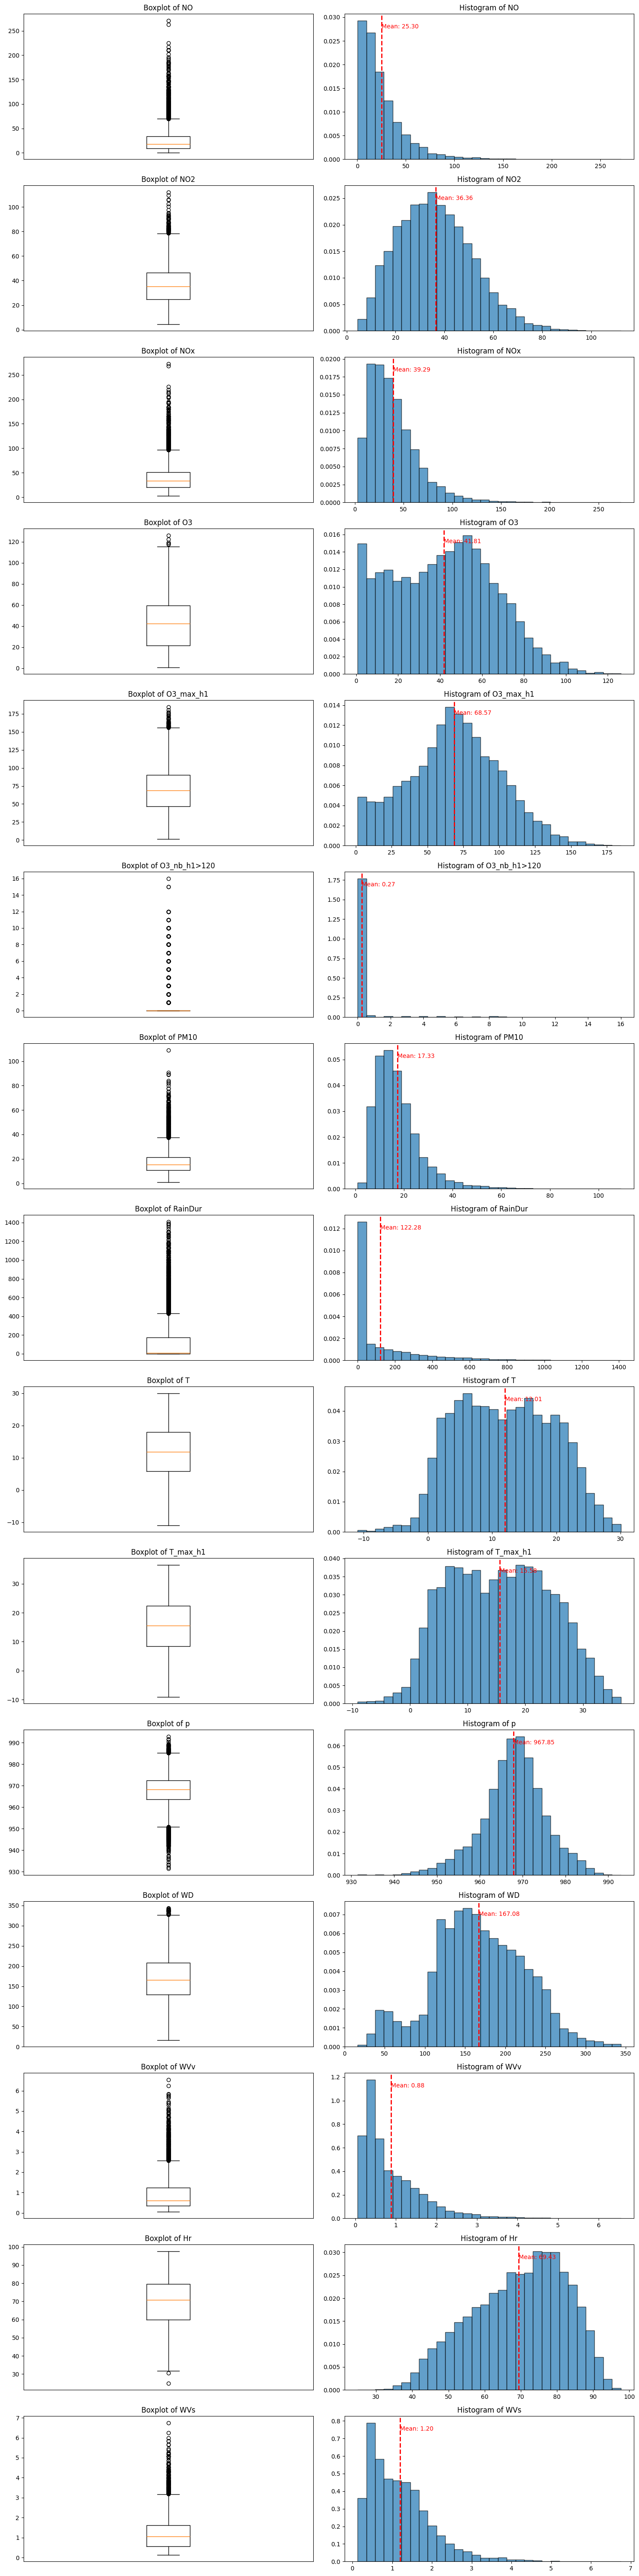

In [25]:
columns_with_missing_values = [
    "NO", "NO2", "NOx", "O3", "O3_max_h1", "O3_nb_h1>120", "PM10",
    "RainDur", "T", "T_max_h1", "p", "WD", "WVv", "Hr", 'WVs'
]

fig, axes = plt.subplots(nrows=len(columns_with_missing_values), ncols=2, figsize=(15, 4 * len(columns_with_missing_values)))

for i, column_name in enumerate(columns_with_missing_values):
    # Select the right axes for boxplot and histogram
    ax_box = axes[i, 0]
    ax_hist = axes[i, 1]

    # Drop NaN values from the column
    column_data = train_set[column_name].dropna()

    # Boxplot
    ax_box.boxplot(column_data)
    ax_box.set_title(f'Boxplot of {column_name}')
    ax_box.set_xticks([])

    # Histogram
    bin_count = 30  # Increased number of bins for more detail
    ax_hist.hist(column_data, bins=bin_count, edgecolor='black', alpha=0.7, density=True)
    ax_hist.set_title(f'Histogram of {column_name}')

    # Calculate and plot the mean
    mean = column_data.mean()
    ax_hist.axvline(mean, color='red', linestyle='dashed', linewidth=2)
    ax_hist.text(mean, ax_hist.get_ylim()[1] * 0.9, f'Mean: {mean:.2f}', color='red')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

For rows with a lot of NaN's, regular imputation might not make sense (we would have a lot of similar rows then). Let's find these

In [26]:
# Finding rows with multiple NaN values
rows_with_multiple_nans_train = train_set[train_set.isna().sum(axis=1) > 10]
rows_with_multiple_nans_test = test_set[test_set.isna().sum(axis=1) > 10]

# Identifying the names of features missing in rows with multiple NaNs
missing_features_train = rows_with_multiple_nans_train.isna().apply(lambda x: list(x[x].index), axis=1)
missing_features_train_df = missing_features_train.to_frame(name="Missing Features")
missing_features_test = rows_with_multiple_nans_test.isna().apply(lambda x: list(x[x].index), axis=1)
missing_features_test_df = missing_features_test.to_frame(name="Missing Features")

In [27]:
row_indices_train = missing_features_train.index
row_indices_test = missing_features_test.index
selected_rows_train = train_set.loc[row_indices_train]
selected_rows_test = test_set.loc[row_indices_test]

selected_rows_train

Datum  TotalDailyTraffic                   Street  NO  NO2  NOx  \
1824  2016-12-29                0.0  Zch_Stampfenbachstrasse NaN  NaN  NaN   
2993  2020-03-12            13491.0  Zch_Stampfenbachstrasse NaN  NaN  NaN   
5587  2015-05-29            27654.0      Zch_Schimmelstrasse NaN  NaN  NaN   
5724  2015-10-13            27565.0      Zch_Schimmelstrasse NaN  NaN  NaN   
6636  2018-04-12            30103.0      Zch_Schimmelstrasse NaN  NaN  NaN   
7254  2019-12-21            27330.0      Zch_Schimmelstrasse NaN  NaN  NaN   
7288  2020-01-24            31233.0      Zch_Schimmelstrasse NaN  NaN  NaN   
7312  2020-02-17            27271.0      Zch_Schimmelstrasse NaN  NaN  NaN   
7607  2020-12-08            27947.0      Zch_Schimmelstrasse NaN  NaN  NaN   
7928  2021-10-25            30743.0      Zch_Schimmelstrasse NaN  NaN  NaN   
7962  2021-11-28            28710.0      Zch_Schimmelstrasse NaN  NaN  NaN   
9327  2013-10-03            24281.0   Zch_Rosengartenstrasse NaN  NaN  NaN   
9962  2015-06-30                0.0   Zch_Rosengartenstrasse NaN  NaN  NaN   
10217 2016-03-11            26543.0   Zch_Rosengartenstrasse NaN  NaN  NaN   
10358 2016-07-30            16131.0   Zch_Rosengartenstrasse NaN  NaN  NaN   
11189 2018-11-08            27149.0   Zch_Rosengartenstrasse NaN  NaN  NaN   
12194 2021-08-09            21690.0   Zch_Rosengartenstrasse NaN  NaN  NaN   
12224 2021-09-08            26434.0   Zch_Rosengartenstrasse NaN  NaN  NaN   
12606 2022-09-27            27706.0   Zch_Rosengartenstrasse NaN  NaN  NaN   
12684 2022-12-14            26581.0   Zch_Rosengartenstrasse NaN  NaN  NaN   

       O3  O3_max_h1  O3_nb_h1>120  PM10  ...  Weekday_6  1.5km_green  \
1824  NaN        NaN           NaN   NaN  ...      False         7471   
2993  NaN        NaN           NaN   NaN  ...      False         7471   
5587  NaN        NaN           NaN   NaN  ...      False         8273   
5724  NaN        NaN           NaN   NaN  ...      False         8273   
6636  NaN        NaN           NaN   NaN  ...      False         8273   
7254  NaN        NaN           NaN   NaN  ...      False         8273   
7288  NaN        NaN           NaN   NaN  ...      False         8273   
7312  NaN        NaN           NaN   NaN  ...      False         8273   
7607  NaN        NaN           NaN   NaN  ...      False         8273   
7928  NaN        NaN           NaN   NaN  ...      False         8273   
7962  NaN        NaN           NaN   NaN  ...       True         8273   
9327  NaN        NaN           NaN   NaN  ...      False         8289   
9962  NaN        NaN           NaN   NaN  ...      False         8289   
10217 NaN        NaN           NaN   NaN  ...      False         8289   
10358 NaN        NaN           NaN   NaN  ...      False         8289   
11189 NaN        NaN           NaN   NaN  ...      False         8289   
12194 NaN        NaN           NaN   NaN  ...      False         8289   
12224 NaN        NaN           NaN   NaN  ...      False         8289   
12606 NaN        NaN           NaN   NaN  ...      False         8289   
12684 NaN        NaN           NaN   NaN  ...      False         8289   

       1km_green  500m_green  200m_green  1.5km_trees  1km_trees  500m_trees  \
1824        4473        1611         132         9115       4054        1419   
2993        4473        1611         132         9115       4054        1419   
5587        3779         901         140        10143       4389        1138   
5724        3779         901         140        10143       4389        1138   
6636        3779         901         140        10143       4389        1138   
7254        3779         901         140        10143       4389        1138   
7288        3779         901         140        10143       4389        1138   
7312        3779         901         140        10143       4389        1138   
7607        3779         901         140        10143       4389        1138   
7928        3779         901         1

In [28]:
selected_rows_test

Datum  TotalDailyTraffic                  Street  NO  NO2  NOx  O3  \
8400  2023-02-13            33108.0     Zch_Schimmelstrasse NaN  NaN  NaN NaN   
8537  2023-06-30            32896.0     Zch_Schimmelstrasse NaN  NaN  NaN NaN   
8587  2023-08-19            40371.0     Zch_Schimmelstrasse NaN  NaN  NaN NaN   
8654  2023-10-25            34270.0     Zch_Schimmelstrasse NaN  NaN  NaN NaN   
12991 2023-10-19            23449.0  Zch_Rosengartenstrasse NaN  NaN  NaN NaN   

       O3_max_h1  O3_nb_h1>120  PM10  ...  Weekday_6  1.5km_green  1km_green  \
8400         NaN           NaN   NaN  ...      False         8273       3779   
8537         NaN           NaN   NaN  ...      False         8273       3779   
8587         NaN           NaN   NaN  ...      False         8273       3779   
8654         NaN           NaN   NaN  ...      False         8273       3779   
12991        NaN           NaN   NaN  ...      False         8289       3424   

       500m_green  200m_green  1.5km_trees  1km_trees  500m_trees  200m_trees  \
8400          901         140        10143       4389        1138         124   
8537          901         140        10143       4389        1138         124   
8587          901         140        10143       4389        1138         124   
8654          901         140        10143       4389        1138         124   
12991        1271         219         9730       3376         918         179   

       NO2_tomorrow  
8400          44.38  
8537           7.86  
8587          27.41  
8654          23.48  
12991         32.96  

[5 rows x 38 columns]

We find that there are 20 rows in the train set and 5 rows in the test set where all meteo data is missing. In order to impute those values, we take the average of the respective meteo data from the day before and the next day. We see that the rows are not at the end/beginning of a specific street, hence we know that the previous/next column will correspond to yesterday's/tomorrow's values.

In [29]:
# Function to get value if index exists, else None
def get_value_if_exists(df, idx, column):
    if idx in df.index:
        return df.loc[idx, column]
    return None

# Impute missing values for train set
for idx in missing_features_train_df.index:
    for column in missing_features_train_df.loc[idx, "Missing Features"]:
        prev_day_value = get_value_if_exists(train_set, idx - 1, column) or get_value_if_exists(train_set, idx - 2, column)
        next_day_value = get_value_if_exists(train_set, idx + 1, column) or get_value_if_exists(train_set, idx + 2, column)

        if pd.notna(prev_day_value) and pd.notna(next_day_value):
            mean_value = (prev_day_value + next_day_value) / 2
            train_set.loc[idx, column] = mean_value

# Impute missing values for test set
for idx in missing_features_test_df.index:
    for column in missing_features_test_df.loc[idx, "Missing Features"]:
        prev_day_value = get_value_if_exists(test_set, idx - 1, column) or get_value_if_exists(test_set, idx - 2, column)
        next_day_value = get_value_if_exists(test_set, idx + 1, column) or get_value_if_exists(test_set, idx + 2, column)

        if pd.notna(prev_day_value) and pd.notna(next_day_value):
            mean_value = (prev_day_value + next_day_value) / 2
            test_set.loc[idx, column] = mean_value

# The df DataFrame now has imputed values
selected_rows_train = train_set.loc[row_indices_train]
selected_rows_train

Datum  TotalDailyTraffic                   Street      NO     NO2  \
1824  2016-12-29                0.0  Zch_Stampfenbachstrasse  23.195  45.050   
2993  2020-03-12            13491.0  Zch_Stampfenbachstrasse   3.715  18.410   
5587  2015-05-29            27654.0      Zch_Schimmelstrasse     NaN     NaN   
5724  2015-10-13            27565.0      Zch_Schimmelstrasse     NaN     NaN   
6636  2018-04-12            30103.0      Zch_Schimmelstrasse     NaN     NaN   
7254  2019-12-21            27330.0      Zch_Schimmelstrasse     NaN     NaN   
7288  2020-01-24            31233.0      Zch_Schimmelstrasse     NaN     NaN   
7312  2020-02-17            27271.0      Zch_Schimmelstrasse     NaN     NaN   
7607  2020-12-08            27947.0      Zch_Schimmelstrasse     NaN     NaN   
7928  2021-10-25            30743.0      Zch_Schimmelstrasse     NaN     NaN   
7962  2021-11-28            28710.0      Zch_Schimmelstrasse     NaN     NaN   
9327  2013-10-03            24281.0   Zch_Rosengartenstrasse     NaN     NaN   
9962  2015-06-30                0.0   Zch_Rosengartenstrasse     NaN     NaN   
10217 2016-03-11            26543.0   Zch_Rosengartenstrasse     NaN     NaN   
10358 2016-07-30            16131.0   Zch_Rosengartenstrasse     NaN     NaN   
11189 2018-11-08            27149.0   Zch_Rosengartenstrasse     NaN     NaN   
12194 2021-08-09            21690.0   Zch_Rosengartenstrasse  17.065  31.315   
12224 2021-09-08            26434.0   Zch_Rosengartenstrasse     NaN     NaN   
12606 2022-09-27            27706.0   Zch_Rosengartenstrasse  19.210  31.940   
12684 2022-12-14            26581.0   Zch_Rosengartenstrasse     NaN     NaN   

          NOx      O3  O3_max_h1  O3_nb_h1>120    PM10  ...  Weekday_6  \
1824   42.160  10.340     20.635           0.0  24.905  ...      False   
2993   12.610  59.080     78.130           0.0   6.335  ...      False   
5587      NaN     NaN        NaN           NaN     NaN  ...      False   
5724      NaN     NaN        NaN           NaN     NaN  ...      False   
6636      NaN     NaN        NaN           NaN     NaN  ...      False   
7254      NaN     NaN        NaN           NaN     NaN  ...      False   
7288      NaN     NaN        NaN           NaN     NaN  ...      False   
7312      NaN     NaN        NaN           NaN     NaN  ...      False   
7607      NaN     NaN        NaN           NaN     NaN  ...      False   
7928      NaN     NaN        NaN           NaN     NaN  ...      False   
7962      NaN     NaN        NaN           NaN     NaN  ...       True   
9327      NaN     NaN        NaN           NaN     NaN  ...      False   
9962      NaN     NaN        NaN           NaN     NaN  ...      False   
10217     NaN     NaN        NaN           NaN     NaN  ...      False   
10358     NaN     NaN        NaN           NaN     NaN  ...      False   
11189     NaN     NaN        NaN           NaN     NaN  ...      False   
12194  30.060  36.410     63.575           0.0  11.060  ...      False   
12224     NaN     NaN        NaN           NaN     NaN  ...      False   
12606  32.105  33.995     55.510           0.0   7.295  ...      False   
12684     NaN     NaN        NaN           NaN     NaN  ...      False   

       1.5km_green  1km_green  500m_green  200m_green  1.5km_trees  1km_trees  \
1824          7471       4473        1611         132         9115       4054   
2993          7471       4473        1611         132         9115       4054   
5587          8273       3779         901         140        10143       4389   
5724          8273       3779         901         140        10143       4389   
6636          8273       3779         901         140        10143       4389   
7254          8273       3779         901         140        10143       4389   
7288          8273       3779         901         140        10143       4389   
7312          8273       3779         901         140        10143       4389   
7607          8273       3779         901     

In [30]:
selected_rows_test = test_set.loc[row_indices_test]
selected_rows_test

Datum  TotalDailyTraffic                  Street      NO     NO2  \
8400  2023-02-13            33108.0     Zch_Schimmelstrasse     NaN     NaN   
8537  2023-06-30            32896.0     Zch_Schimmelstrasse     NaN     NaN   
8587  2023-08-19            40371.0     Zch_Schimmelstrasse   2.905  22.460   
8654  2023-10-25            34270.0     Zch_Schimmelstrasse     NaN     NaN   
12991 2023-10-19            23449.0  Zch_Rosengartenstrasse  23.110  30.915   

          NOx     O3  O3_max_h1  O3_nb_h1>120    PM10  ...  Weekday_6  \
8400      NaN    NaN        NaN           NaN     NaN  ...      False   
8537      NaN    NaN        NaN           NaN     NaN  ...      False   
8587   14.075  76.36    133.945           4.0  20.730  ...      False   
8654      NaN    NaN        NaN           NaN     NaN  ...      False   
12991  34.695  18.42     40.755           0.0  18.215  ...      False   

       1.5km_green  1km_green  500m_green  200m_green  1.5km_trees  1km_trees  \
8400          8273       3779         901         140        10143       4389   
8537          8273       3779         901         140        10143       4389   
8587          8273       3779         901         140        10143       4389   
8654          8273       3779         901         140        10143       4389   
12991         8289       3424        1271         219         9730       3376   

       500m_trees  200m_trees  NO2_tomorrow  
8400         1138         124         44.38  
8537         1138         124          7.86  
8587         1138         124         27.41  
8654         1138         124         23.48  
12991         918         179         32.96  

[5 rows x 38 columns]

We see that we were able to impute some of the missing values. however, for the most rows, the neighboring rows were already deleted before due to missing values in the target variable. for the rest of the variables, it makes no sense to impute. we would then have multiple columns full of the same values, but with different target varibales. this would strongly distort our model. hence we will delete the rest of these rows. 

In [31]:
#removing the rows for which this imputation technique did not work

rows_to_drop_train = [idx for idx in missing_features_train_df.index if train_set.loc[idx].isna().sum() > 10]
rows_to_drop_test = [idx for idx in missing_features_test_df.index if test_set.loc[idx].isna().sum() > 10]
train_set.drop(rows_to_drop_train, inplace=True)
test_set.drop(rows_to_drop_test, inplace=True)

**Missing Data in the TotalDailyTraffic Column**

now we take a look at the TotalDailyTraffic. Because we calculated it ourselves, there are no NaN but possibly zero

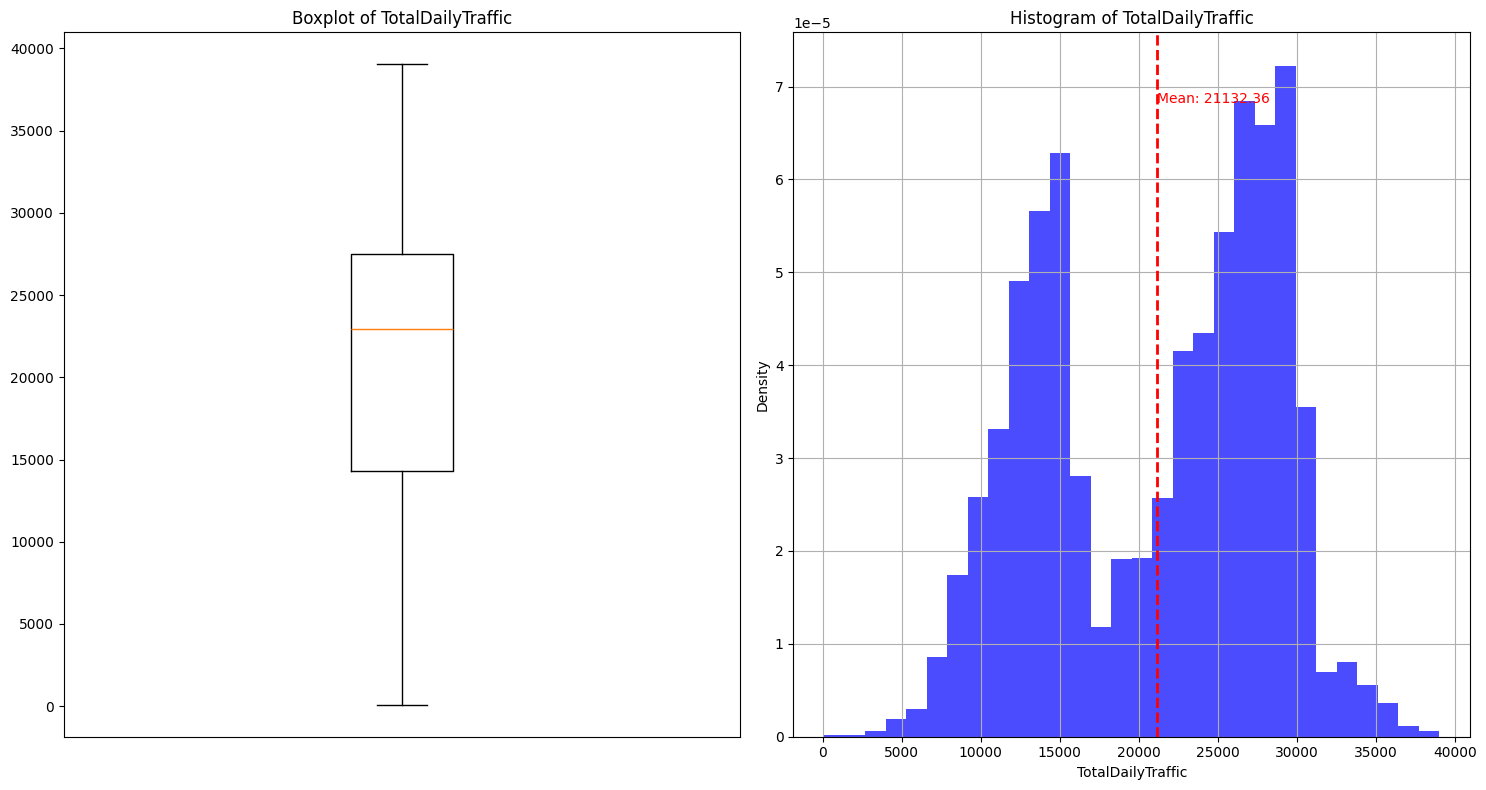

In [32]:
train_set['TotalDailyTraffic'] = train_set['TotalDailyTraffic'].replace(0, np.nan)
test_set['TotalDailyTraffic'] = test_set['TotalDailyTraffic'].replace(0, np.nan)

column_data = train_set['TotalDailyTraffic'].dropna()

# Adding a boxplot to the left of the histogram for 'TotalDailyTraffic'
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

# Boxplot
axes[0].boxplot(column_data)
axes[0].set_title('Boxplot of TotalDailyTraffic')
axes[0].set_xticks([])

# Histogram
axes[1].hist(column_data, bins=30, color='blue', alpha=0.7, density=True)
axes[1].set_title('Histogram of TotalDailyTraffic')
axes[1].set_xlabel('TotalDailyTraffic')
axes[1].set_ylabel('Density')
axes[1].grid(True)

# Adding mean to the histogram
mu = column_data.mean()
axes[1].axvline(mu, color='red', linestyle='dashed', linewidth=2)
axes[1].text(mu, axes[1].get_ylim()[1] * 0.9, f'Mean: {mu:.2f}', color='red')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

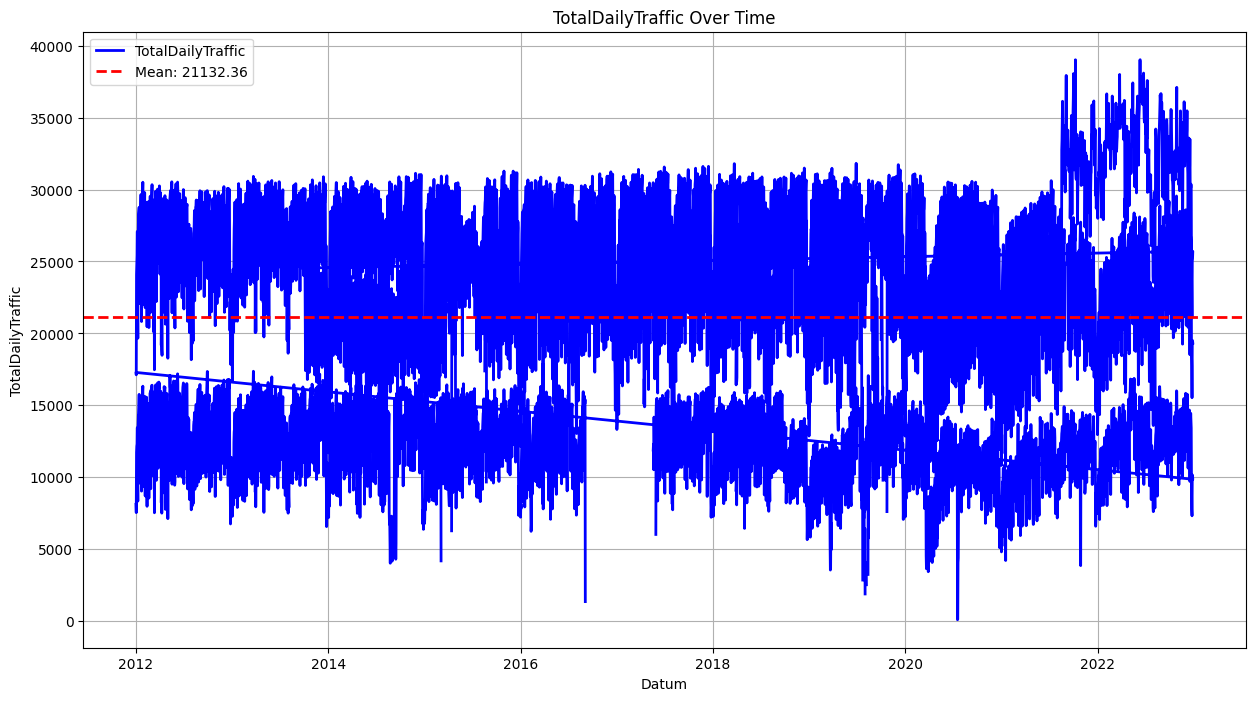

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming 'Datum' is the time-related variable
train_set['TotalDailyTraffic'] = train_set['TotalDailyTraffic'].replace(0, np.nan)
test_set['TotalDailyTraffic'] = test_set['TotalDailyTraffic'].replace(0, np.nan)

# Assuming you have a 'Datum' column
train_set['Datum'] = pd.to_datetime(train_set['Datum'])
test_set['Datum'] = pd.to_datetime(test_set['Datum'])

# Plotting 'TotalDailyTraffic' over time
plt.figure(figsize=(15, 8))

# Line plot
plt.plot(train_set['Datum'], train_set['TotalDailyTraffic'], label='TotalDailyTraffic', color='blue', linewidth=2)

# Adding mean line to the plot
mean_traffic = train_set['TotalDailyTraffic'].mean()
plt.axhline(mean_traffic, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_traffic:.2f}')

# Setting labels and title
plt.xlabel('Datum')
plt.ylabel('TotalDailyTraffic')
plt.title('TotalDailyTraffic Over Time')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


The Total Daily Traffic is more difficult to impute, as it we have high values around the edges. We can try distinguishing Weekends (including Friday) and Weekdays

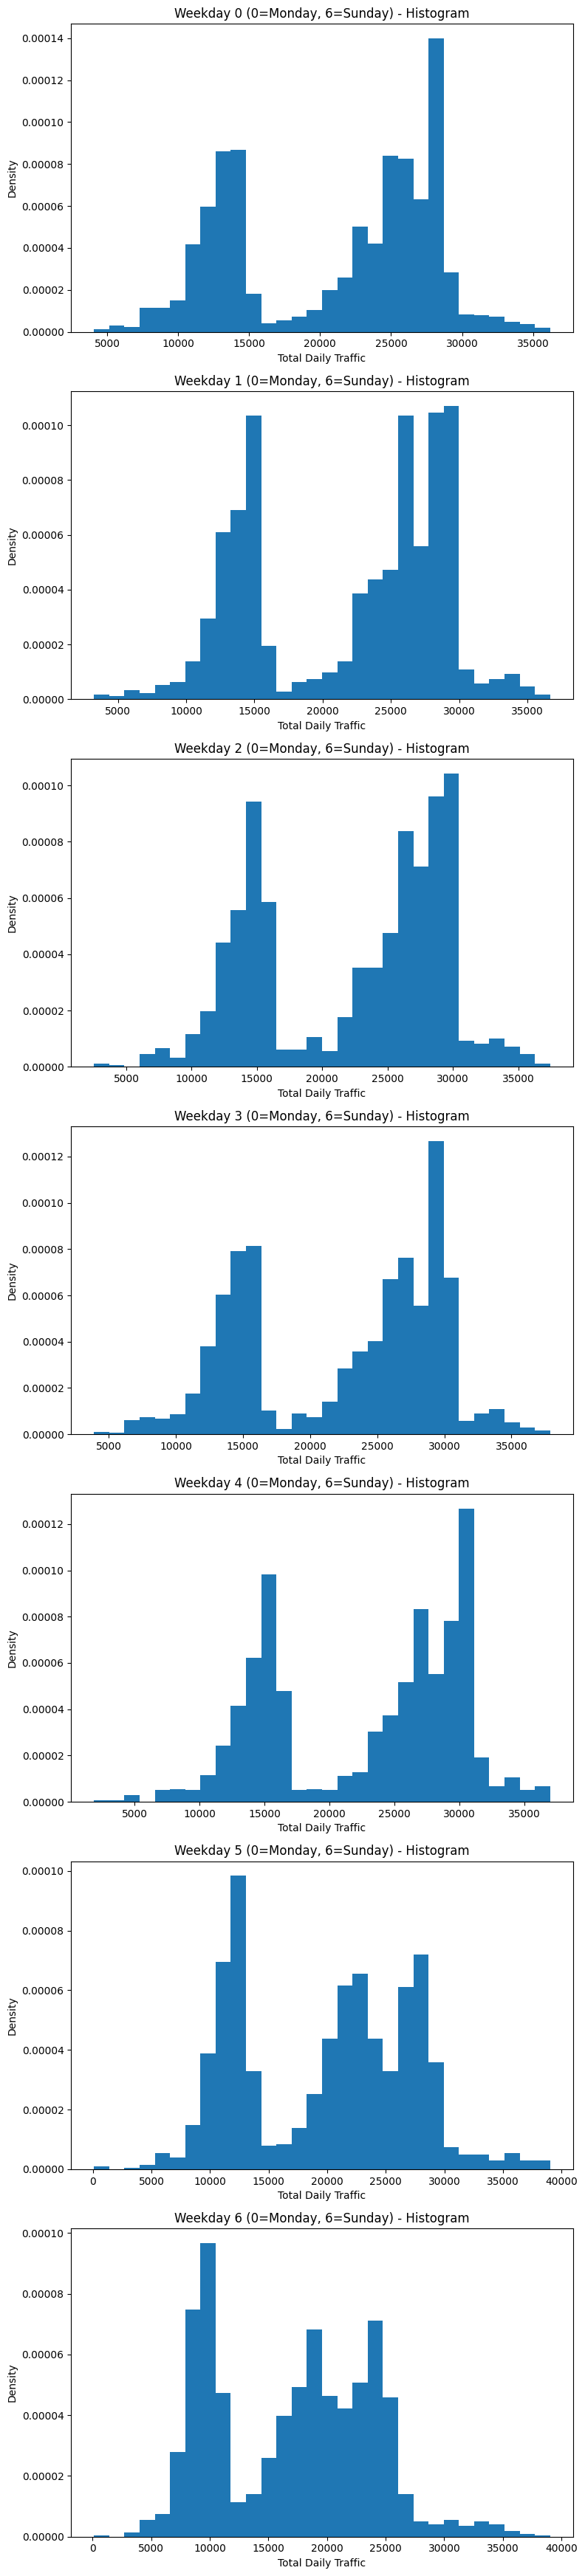

In [34]:
# Plotting distributions for each day of the week using 'Weekday_X' columns
plt.figure(figsize=(15, 35))
for i in range(7):
    
    # Filtering data for each weekday
    weekday_data = train_set[train_set[f'Weekday_{i}'] == 1]['TotalDailyTraffic']
    weekday_data = weekday_data.dropna()

    # Creating subplot for histogram 
    ax_hist = plt.subplot(7, 2, 2*i+1)
    ax_hist.hist(weekday_data, bins=30, density=True)
    ax_hist.set_title(f'Weekday {i} (0=Monday, 6=Sunday) - Histogram')
    ax_hist.set_xlabel('Total Daily Traffic')
    ax_hist.set_ylabel('Density')

plt.tight_layout()
plt.show()

We still observe the same distribution. Let's go ahead and try to work with median imputation

In [35]:
# Calculate the median of 'TotalDailyTraffic'
median_traffic_train = train_set['TotalDailyTraffic'].median()

# Replace NaN values with the median
train_set['TotalDailyTraffic'] = train_set['TotalDailyTraffic'].fillna(median_traffic_train)
test_set['TotalDailyTraffic'] = test_set['TotalDailyTraffic'].fillna(median_traffic_train)


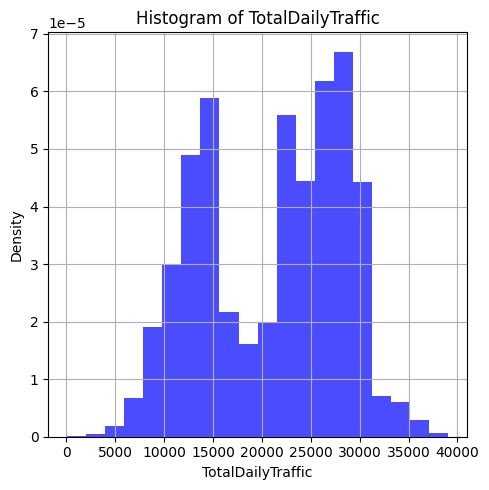

In [36]:
plt.figure(figsize=(5, 5))

column_data = train_set['TotalDailyTraffic']
plt.hist(column_data, bins=20, color='blue', alpha=0.7, density=True)
plt.title('Histogram of TotalDailyTraffic')
plt.xlabel('TotalDailyTraffic')
plt.ylabel('Density')
plt.grid(True)

# Calculate mean and standard deviation
mu = column_data.mean()
sigma = column_data.std()

# Generate a range of values
x = np.linspace(column_data.min(), column_data.max(), 100)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

we will work with that

**Filling the rest of the columns' NaN Values**

For those with small or no outliers, we will use the mean to impute. These are the following columns: "O3", "O3_max_h1", "O3_nb_h1>120", "T", "T_max_h1", "WD", "Hr"

For those with a a lot and strong outliers, we will use the median, as it is more robust to those. These are the following columns: 'NO', 'NO2', 'NOx', 'PM10', 'RainDur', 'p' ,'WVv', 'WVs'

In [73]:
# Define the columns with normal distribution and skewed distribution
columns_little_outliers = ["O3", "O3_max_h1", "O3_nb_h1>120", "T", "T_max_h1", "WD", "Hr"]
columns_many_outliers = ['NO', 'NO2', 'NOx', 'PM10', 'RainDur', 'p', 'WVv', 'WVs']

# Impute NaNs in columns with little outliers using the mean
mean_values_train = train_set[columns_little_outliers].mean()
train_set[columns_little_outliers] = train_set[columns_little_outliers].fillna(mean_values_train)
test_set[columns_little_outliers] = test_set[columns_little_outliers].fillna(mean_values_train)

# Impute NaNs in columns with a lot of outliers using the median
median_values_train = train_set[columns_many_outliers].median()
train_set[columns_many_outliers] = train_set[columns_many_outliers].fillna(median_values_train)
test_set[columns_many_outliers] = test_set[columns_many_outliers].fillna(median_values_train)

# Check if there are any NaN values left in the specified columns
nan_after_imputation_train = train_set[columns_little_outliers + columns_many_outliers].isna().sum() == 0
nan_after_imputation_test = test_set[columns_little_outliers + columns_many_outliers].isna().sum() == 0

# Output whether all values are True
print("All NaNs imputed in train_set:", all(nan_after_imputation_train))
print("All NaNs imputed in test_set:", all(nan_after_imputation_test))


All NaNs imputed in train_set: True
All NaNs imputed in test_set: True


### Feature Engineering: Reducing Multicollinearity

In order to mitigate potential issues related to multicollinearity in our regression model, we will apply a technique known as the 'dummy variable trap' to the categorical features representing months and weekdays. The dummy variable trap arises when there is high correlation among dummy variables, and it can adversely impact the performance of the regression model.

Specifically, for the categorical feature 'Month,' we will create dummy variables for each month but drop one to avoid perfect multicollinearity. Similarly, for the categorical feature 'Weekday,' we will create dummy variables for each weekday but drop one. This approach ensures that the model does not fall into the dummy variable trap by excluding redundant information that can be inferred from other dummy variables.


In [38]:
train_set.drop(columns=['Weekday_6', 'Season_4'], inplace=True)
test_set.drop(columns=['Weekday_6', 'Season_4'], inplace=True)

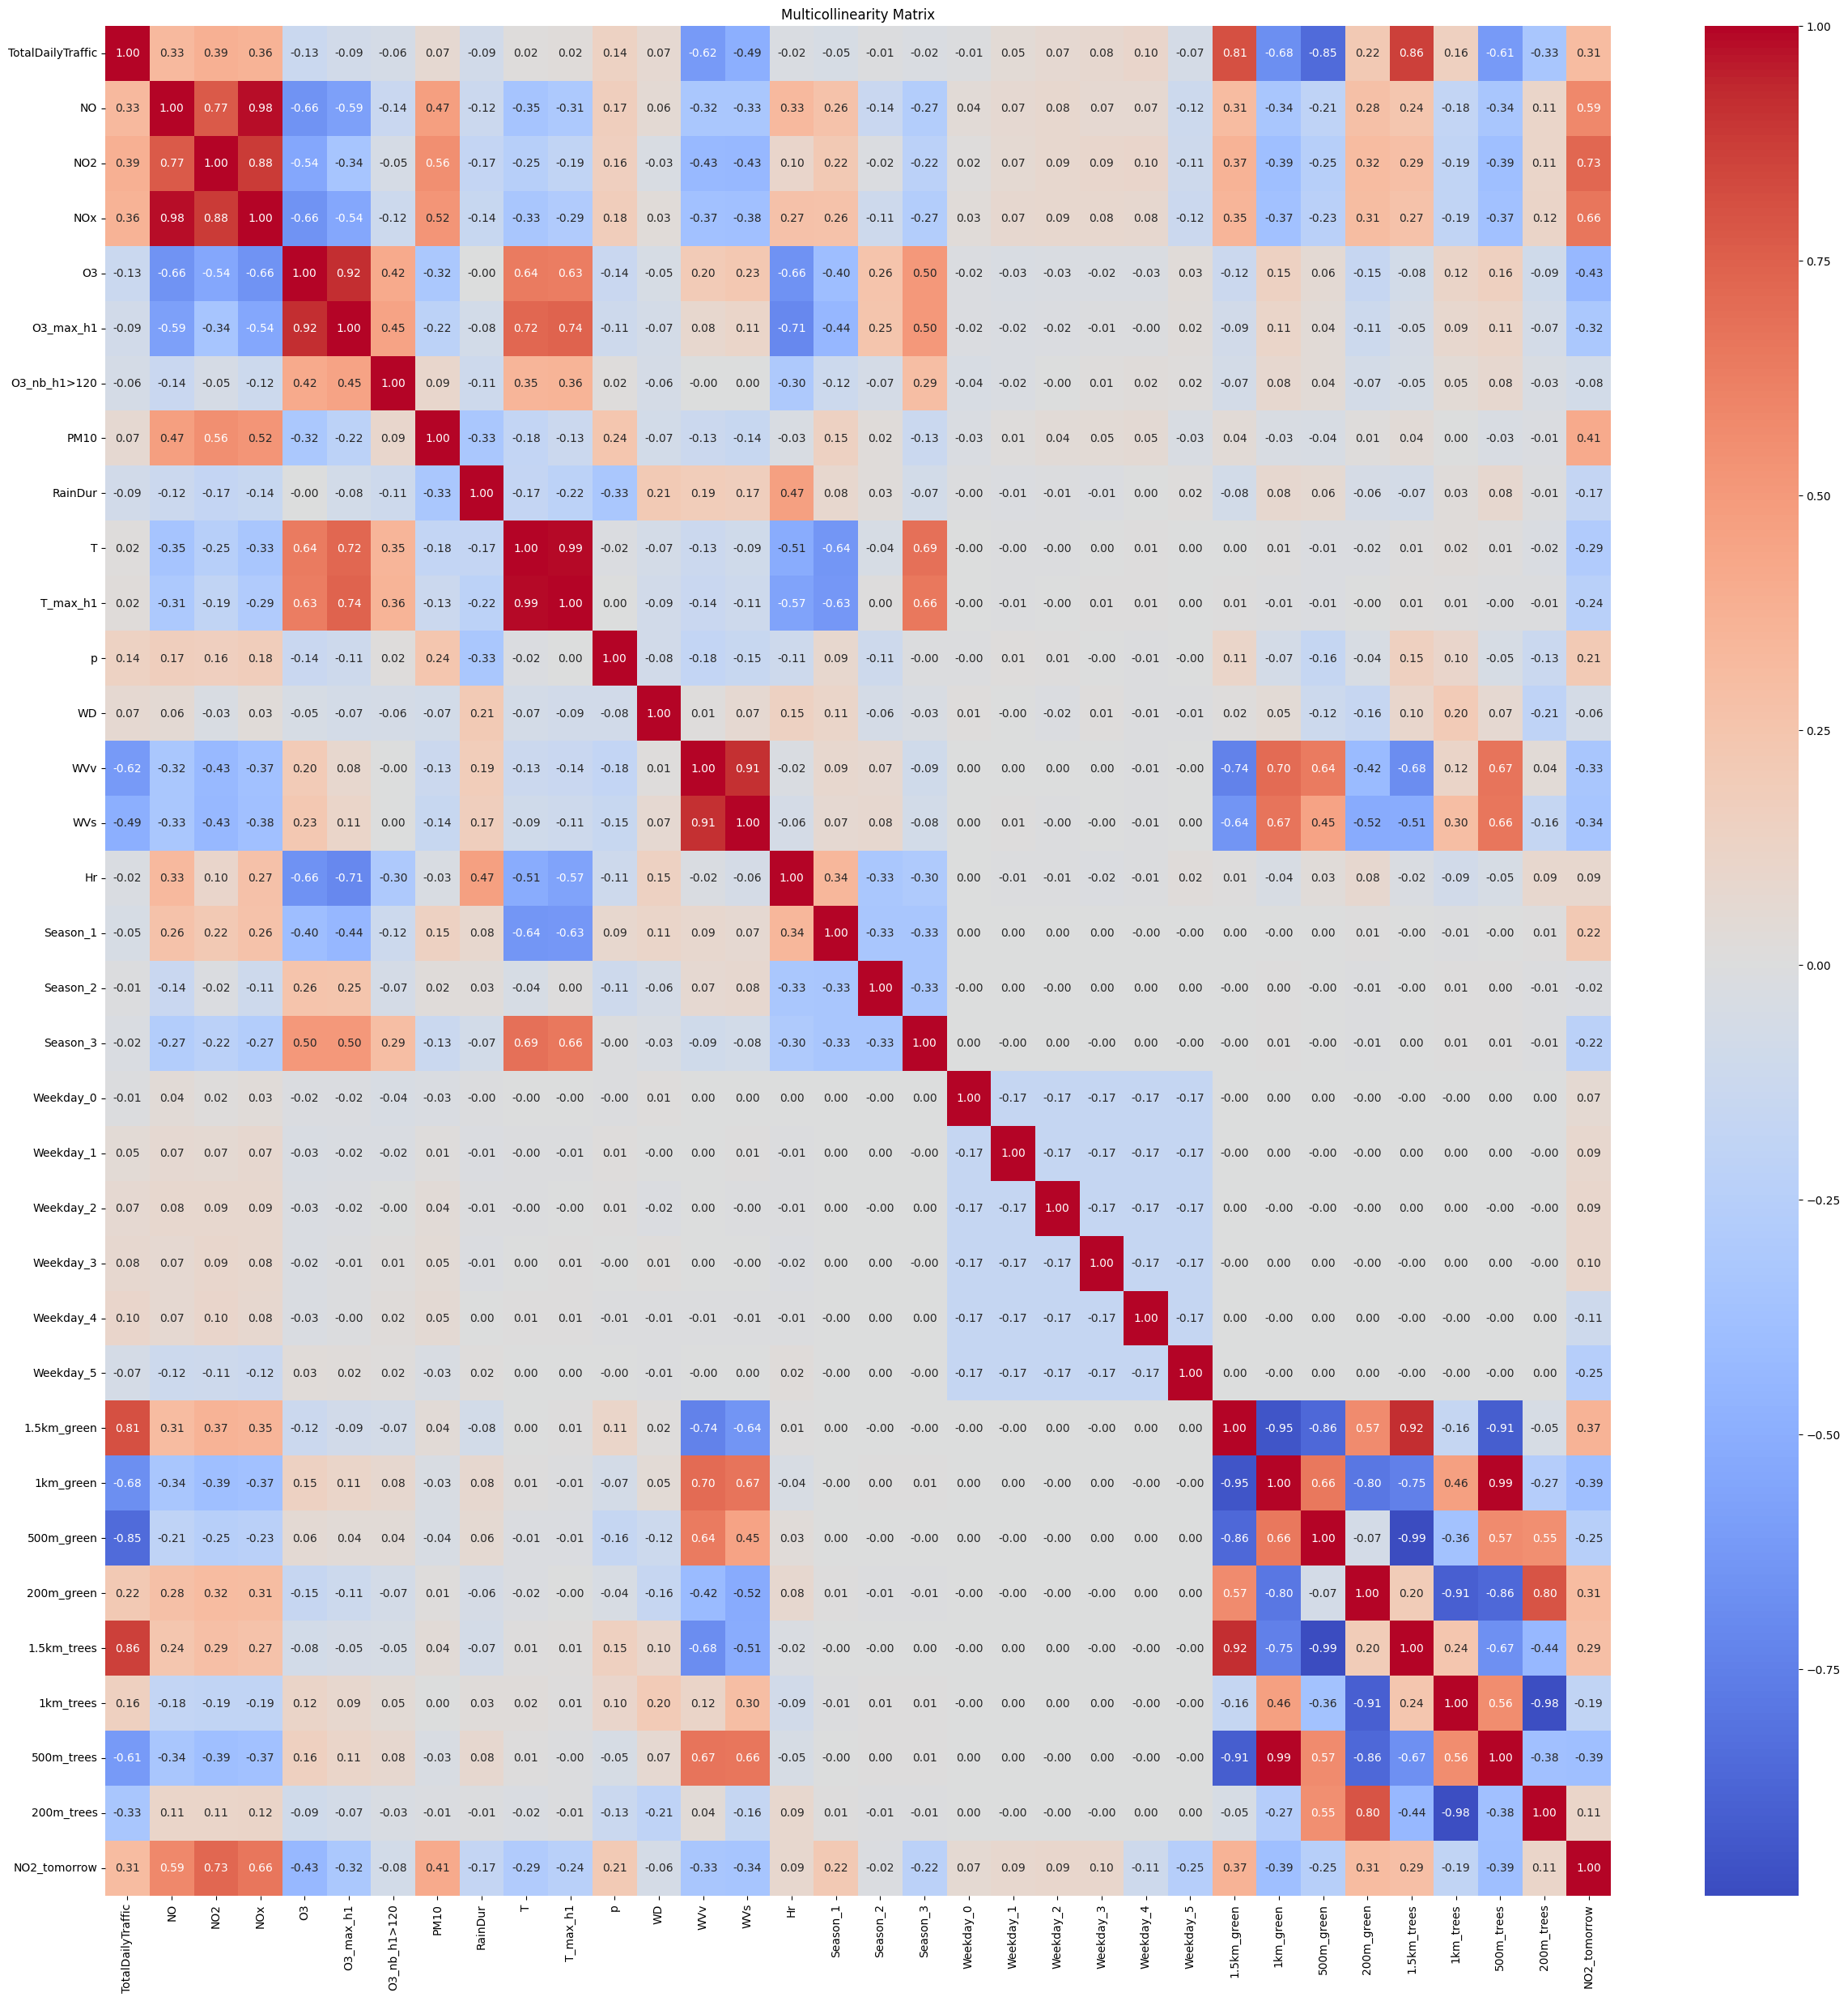

In [39]:
corr_matrix = train_set.drop(columns=['Datum', 'Street']).corr()

# Use a heatmap to visualize the correlation matrix
plt.figure(figsize=(30, 30))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Multicollinearity Matrix')
plt.show()

2. From the multicollinearity matrix we see that we have some features which are highly correlated. In order to improve the performance of our model, we will delete one of the two features, if the multicollinearity is higher than 0.8

In [40]:
high_corr_var = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            colname = corr_matrix.columns[i]
            high_corr_var.add(colname)

# Remove the identified features
train_reduced = train_set.drop(columns=high_corr_var)
test_reduced = test_set.drop(columns=high_corr_var)

### Feature Engineering: Polynomials

We build some polynomial features to capture possible, non linear relationships

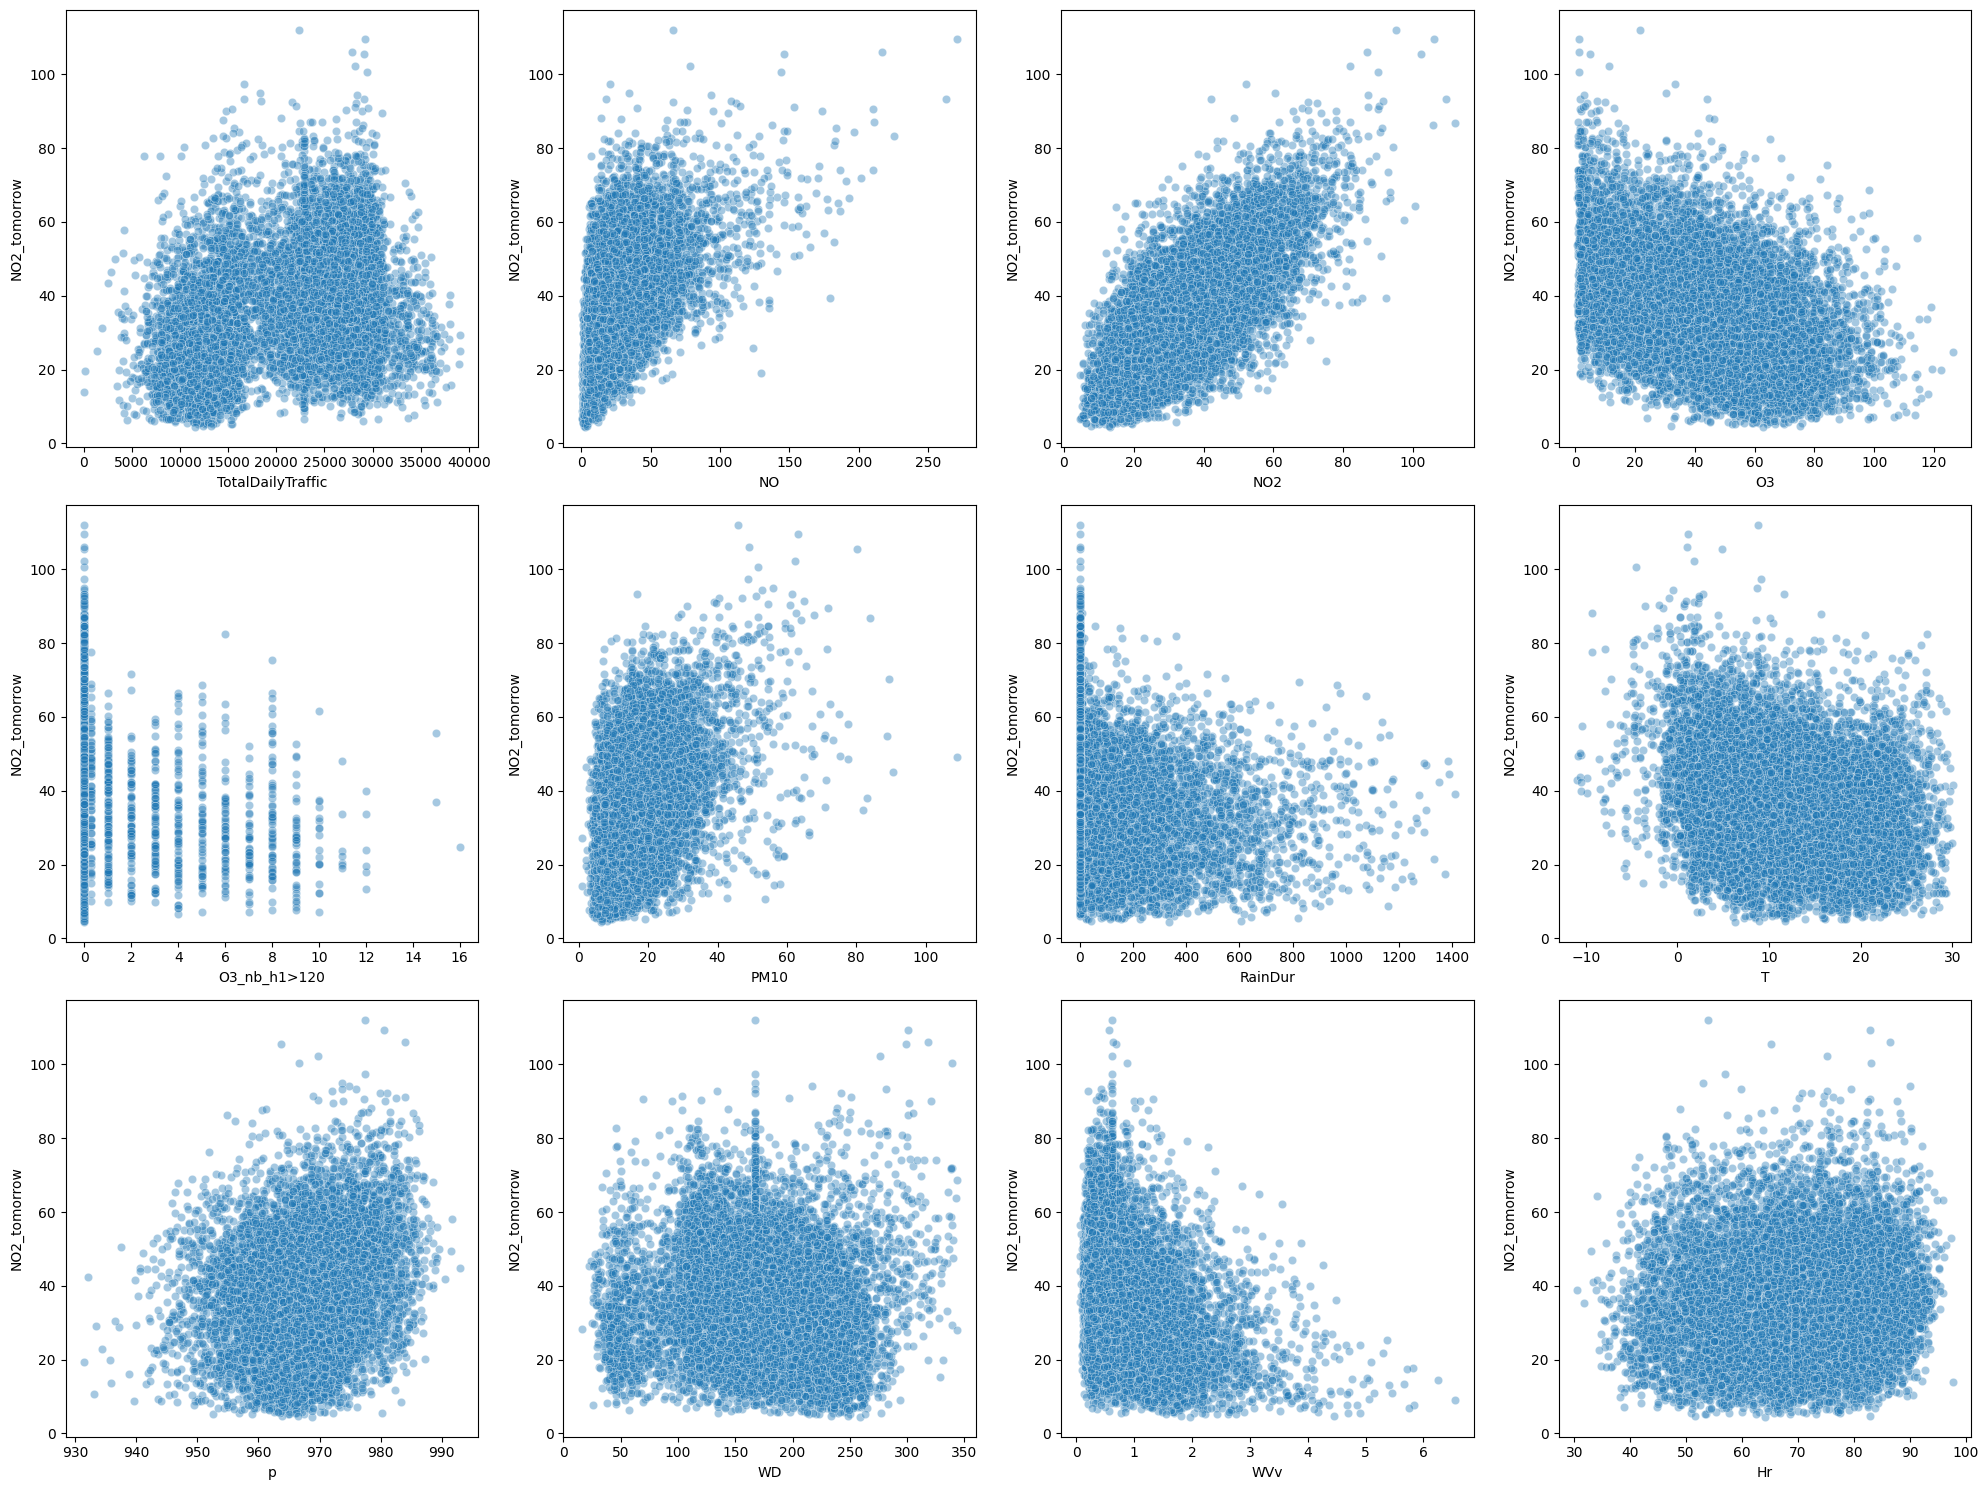

In [41]:
#plot features to see the relationships

# Selecting a subset of columns for plotting
# Excluding non-numerical columns and the target variable itself
plot_columns = train_reduced.select_dtypes(include=['float64', 'int64']).columns.drop(['NO2_tomorrow'])

# Define the number of plots: 4 columns in each row
num_columns = 4
num_rows = len(plot_columns) // num_columns + (1 if len(plot_columns) % num_columns else 0)

# Create a figure with subplots
plt.figure(figsize=(20, 5 * num_rows))

# Plotting each feature against 'NO2_tomorrow'
for i, column in enumerate(plot_columns, 1):
    plt.subplot(num_rows, num_columns, i)
    sns.scatterplot(x=train_reduced[column], y=train_reduced['NO2_tomorrow'], alpha=0.4)
    plt.xlabel(column)
    plt.ylabel('NO2_tomorrow')

plt.tight_layout()
plt.show()


Our dataset reveals unclear linear relationships for most features with the target variable, except for NO2. To address this, we consider introducing polynomial features to capture potential non-linear patterns.

In [42]:
from sklearn.preprocessing import PolynomialFeatures

def create_complete_polynomial_features(train_set, test_set, exclude_features, polydegree):
   
    # Selecting numerical features excluding the specified ones
    numerical_features = train_set.select_dtypes(include=['float64', 'int64']).columns
    selected_features = numerical_features.drop(exclude_features)

    # Extracting the selected features from the datasets
    X_train = train_set[selected_features]
    X_test = test_set[selected_features]

    # Creating polynomial features up to the specified degree
    poly = PolynomialFeatures(degree=polydegree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)  # Using the same fit for the test set

    # Creating DataFrames for the polynomial features
    poly_feature_names = poly.get_feature_names_out(selected_features)
    X_train_poly_df = pd.DataFrame(X_train_poly, columns=poly_feature_names, index=train_set.index)
    X_test_poly_df = pd.DataFrame(X_test_poly, columns=poly_feature_names, index=test_set.index)

    # Merging the polynomial features with the original dataset
    # This includes both the numerical features that were not included in the polynomial expansion and any non-numerical features
    train_final = pd.concat([train_set.drop(selected_features, axis=1), X_train_poly_df], axis=1)
    test_final = pd.concat([test_set.drop(selected_features, axis=1), X_test_poly_df], axis=1)

    return train_final, test_final

train_reduced_poly_2, test_reduced_poly_2 = create_complete_polynomial_features(train_reduced, test_reduced, ['NO2', 'NO2_tomorrow'], 2)
train_poly_2, test_poly_2 = create_complete_polynomial_features(train_set, test_set, ['NO2', 'NO2_tomorrow'], 2)
train_reduced_poly_3, test_reduced_poly_3 = create_complete_polynomial_features(train_reduced, test_reduced, ['NO2', 'NO2_tomorrow'], 3)
train_poly_3, test_poly_3 = create_complete_polynomial_features(train_set, test_set, ['NO2', 'NO2_tomorrow'], 3)
train_reduced_poly_4, test_reduced_poly_4 = create_complete_polynomial_features(train_reduced, test_reduced, ['NO2', 'NO2_tomorrow'], 4)
train_poly_4, test_poly_4 = create_complete_polynomial_features(train_set, test_set, ['NO2', 'NO2_tomorrow'], 4)

# Model Testing

In this section, we evaluate the predictive performance of our models using two distinct algorithms: Linear Regression and Random Forests. Each model brings its own set of strengths and characteristics to the task of predicting NO2 levels for our dataset.

## Linear Regression 

In [118]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Define your dataset pairs
dataset_pairs = [
    ('train_set', train_set, 'test_set', test_set),
    ('train_reduced', train_reduced, 'test_reduced', test_reduced),
    ('train_poly_2', train_poly_2, 'test_poly_2', test_poly_2),
    ('train_reduced_poly_2', train_reduced_poly_2, 'test_reduced_poly_2', test_reduced_poly_2),
    ('train_poly_3', train_poly_3, 'test_poly_3', test_poly_3),
    ('train_reduced_poly_3', train_reduced_poly_3, 'test_reduced_poly_3', test_reduced_poly_3),
    ('train_poly_4', train_poly_4, 'test_poly_4', test_poly_4),
    ('train_reduced_poly_4', train_reduced_poly_4, 'test_reduced_poly_4', test_reduced_poly_4)
]

# Perform standardization for validation data outside the loop
scaler = MinMaxScaler()

# Variables to store results
results_dict = {'MSE': {}, 'R2 Score': {}, 'Adjusted R2 Score': {}}

for train_dataset_name, train_dataset, test_dataset_name, test_dataset in dataset_pairs:
    
    # Preprocess training data
    X_train = train_dataset.drop(columns=['Datum', 'Street', 'NO2_tomorrow'])
    y_train = train_dataset['NO2_tomorrow']

    X_test = test_dataset.drop(columns=['Datum', 'Street', 'NO2_tomorrow'])
    y_test = test_dataset['NO2_tomorrow']

    # Split the training data into training and validation sets
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Standardization
    X_train_scaled = scaler.fit_transform(X_train_split)
    X_val_scaled = scaler.transform(X_val)

    # Lasso for feature selection
    lasso = LassoCV(cv=5, random_state=0, max_iter=100000, tol=0.01).fit(X_train_scaled, y_train_split)
    important_features = lasso.coef_ != 0
    X_train_important = X_train_scaled[:, important_features]
    X_val_important = X_val_scaled[:, important_features]

    # Ridge regression on selected features
    ridge = RidgeCV(alphas=[0.1, 1.0, 10.0]).fit(X_train_important, y_train_split)

    # Evaluate on validation set
    y_pred_val = ridge.predict(X_val_important)
    mse_val = mean_squared_error(y_val, y_pred_val)
    r2_val = r2_score(y_val, y_pred_val)
    
    # Calculate adjusted R2 for validation set
    n = X_val_important.shape[0]
    k = X_val_important.shape[1]
    adjusted_r2_val = 1 - ((1 - r2_val) * (n - 1) / (n - k - 1))

    print(f"\nDataset Pair: {train_dataset_name}")
    print(f"Training Set - Validation MSE: {mse_val:.2f}, Validation R2 Score: {r2_val:.2f}, Adjusted R2 Score: {adjusted_r2_val:.2f}")
    print(f"Selected Ridge Alpha: {ridge.alpha_}\n")

    # Code for final evaluation on the test set
    X_test_scaled = scaler.transform(X_test)
    X_test_important = X_test_scaled[:, important_features]
    y_pred_test = ridge.predict(X_test_important)
    mse_test = mean_squared_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)
    
    # Calculate adjusted R2 for test set
    n_test = X_test_important.shape[0]
    k_test = X_test_important.shape[1]
    adjusted_r2_test = 1 - ((1 - r2_test) * (n_test - 1) / (n_test - k_test - 1))

    print(f"Test Set - Test MSE: {mse_test:.2f}, Test R2 Score: {r2_test:.2f}, Adjusted R2 Score: {adjusted_r2_test:.2f}\n")

    # Store results in the dictionary
    results_dict['MSE'][f"{train_dataset_name} / {test_dataset_name}"] = mse_test
    results_dict['R2 Score'][f"{train_dataset_name} / {test_dataset_name}"] = r2_test
    results_dict['Adjusted R2 Score'][f"{train_dataset_name} / {test_dataset_name}"] = adjusted_r2_test



Dataset Pair: train_set
Training Set - Validation MSE: 78.01, Validation R2 Score: 0.68, Adjusted R2 Score: 0.67
Selected Ridge Alpha: 0.1

Test Set - Test MSE: 53.30, Test R2 Score: 0.54, Adjusted R2 Score: 0.53


Dataset Pair: train_reduced
Training Set - Validation MSE: 78.68, Validation R2 Score: 0.67, Adjusted R2 Score: 0.67
Selected Ridge Alpha: 0.1

Test Set - Test MSE: 56.39, Test R2 Score: 0.52, Adjusted R2 Score: 0.51


Dataset Pair: train_poly_2
Training Set - Validation MSE: 74.73, Validation R2 Score: 0.69, Adjusted R2 Score: 0.68
Selected Ridge Alpha: 0.1

Test Set - Test MSE: 52.76, Test R2 Score: 0.55, Adjusted R2 Score: 0.51


Dataset Pair: train_reduced_poly_2
Training Set - Validation MSE: 76.64, Validation R2 Score: 0.68, Adjusted R2 Score: 0.67
Selected Ridge Alpha: 1.0

Test Set - Test MSE: 56.08, Test R2 Score: 0.52, Adjusted R2 Score: 0.49


Dataset Pair: train_poly_3
Training Set - Validation MSE: 74.39, Validation R2 Score: 0.69, Adjusted R2 Score: 0.67
Selec

In [121]:
from sklearn.metrics import mean_squared_error, r2_score

# Define a function for the naive model
def naive_model(X):
    # The naive model predicts tomorrow's NO2 based on today's NO2
    return X['NO2'].values

# Variables to store results
naive_results_dict = {'MSE': {}, 'R2 Score': {}, 'Adjusted R2 Score': {}}

# Choose a single dataset pair
train_dataset_name = 'train_set'
test_dataset_name = 'test_set'
train_dataset = train_set  # replace with the actual dataset you want to use
test_dataset = test_set  # replace with the actual dataset you want to use

# Preprocess training data
X_train = train_dataset.drop(columns=['Datum', 'Street', 'NO2_tomorrow'])
y_train = train_dataset['NO2_tomorrow']

# Predict on training set
y_pred_train_naive = naive_model(X_train[['NO2']])
mse_train_naive = mean_squared_error(y_train, y_pred_train_naive)
r2_train_naive = r2_score(y_train, y_pred_train_naive)

# Calculate adjusted R2 for training set
n_train_naive = X_train[['NO2']].shape[0]
k_train_naive = 1  # Number of predictors, which is 1 for the naive model
adjusted_r2_train_naive = 1 - ((1 - r2_train_naive) * (n_train_naive - 1) / (n_train_naive - k_train_naive - 1))

# Preprocess test data
X_test = test_dataset.drop(columns=['Datum', 'Street', 'NO2_tomorrow'])
y_test = test_dataset['NO2_tomorrow']

# Predict on test set
y_pred_test_naive = naive_model(X_test[['NO2']])
mse_test_naive = mean_squared_error(y_test, y_pred_test_naive)
r2_test_naive = r2_score(y_test, y_pred_test_naive)

# Calculate adjusted R2 for test set
n_test_naive = X_test[['NO2']].shape[0]
k_test_naive = 1  # Number of predictors, which is 1 for the naive model
adjusted_r2_test_naive = 1 - ((1 - r2_test_naive) * (n_test_naive - 1) / (n_test_naive - k_test_naive - 1))

print(f"\nDataset Pair: {train_dataset_name} / {test_dataset_name}")
print(f"Train Set - Naive Model MSE: {mse_train_naive:.2f}, Naive Model R2 Score: {r2_train_naive:.2f}, Adjusted R2 Score: {adjusted_r2_train_naive:.2f}")
print(f"Test Set - Naive Model MSE: {mse_test_naive:.2f}, Naive Model R2 Score: {r2_test_naive:.2f}, Adjusted R2 Score: {adjusted_r2_test_naive:.2f}\n")

# Store results in the dictionary
naive_results_dict['MSE'][f"{train_dataset_name} / {test_dataset_name}"] = mse_test_naive
naive_results_dict['R2 Score'][f"{train_dataset_name} / {test_dataset_name}"] = r2_test_naive
naive_results_dict['Adjusted R2 Score'][f"{train_dataset_name} / {test_dataset_name}"] = adjusted_r2_test_naive


Dataset Pair: train_set / test_set
Train Set - Naive Model MSE: 127.74, Naive Model R2 Score: 0.45, Adjusted R2 Score: 0.45
Test Set - Naive Model MSE: 61.98, Naive Model R2 Score: 0.47, Adjusted R2 Score: 0.47



Best Model Pair on Test Set: train_poly_2 / test_poly_2
Test MSE: 52.76172151783914
Test R2 Score: 0.5479524188811469


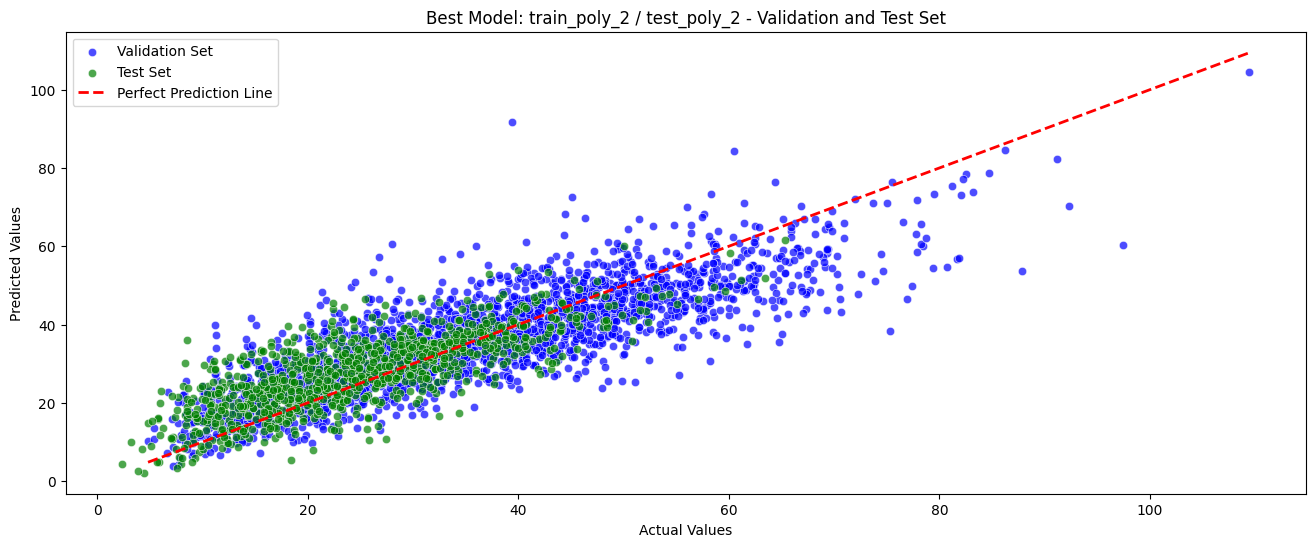

In [122]:
# Display the best model and its scores on the test set
print(f"Best Model Pair on Test Set: {best_model_name}")
print(f"Test MSE: {best_mse}")
print(f"Test R2 Score: {best_r2}")

# Plotting the results for the best model
plt.figure(figsize=(16, 6))
sns.scatterplot(x=y_val, y=y_pred_val, color='blue', alpha=0.7, label='Validation Set')
sns.scatterplot(x=y_test, y=y_pred_test, color='green', alpha=0.7, label='Test Set')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], linestyle='--', color='red', linewidth=2, label='Perfect Prediction Line')
plt.title(f"Best Model: {best_model_name} - Validation and Test Set")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.show()

Best Model Pair on Test Set: train_poly_2 / test_poly_2
Test MSE: 52.76172151783914
Test R2 Score: 0.5479524188811469
Naive Model:
Test MSE: 61.98
Test R2 Score: 0.47


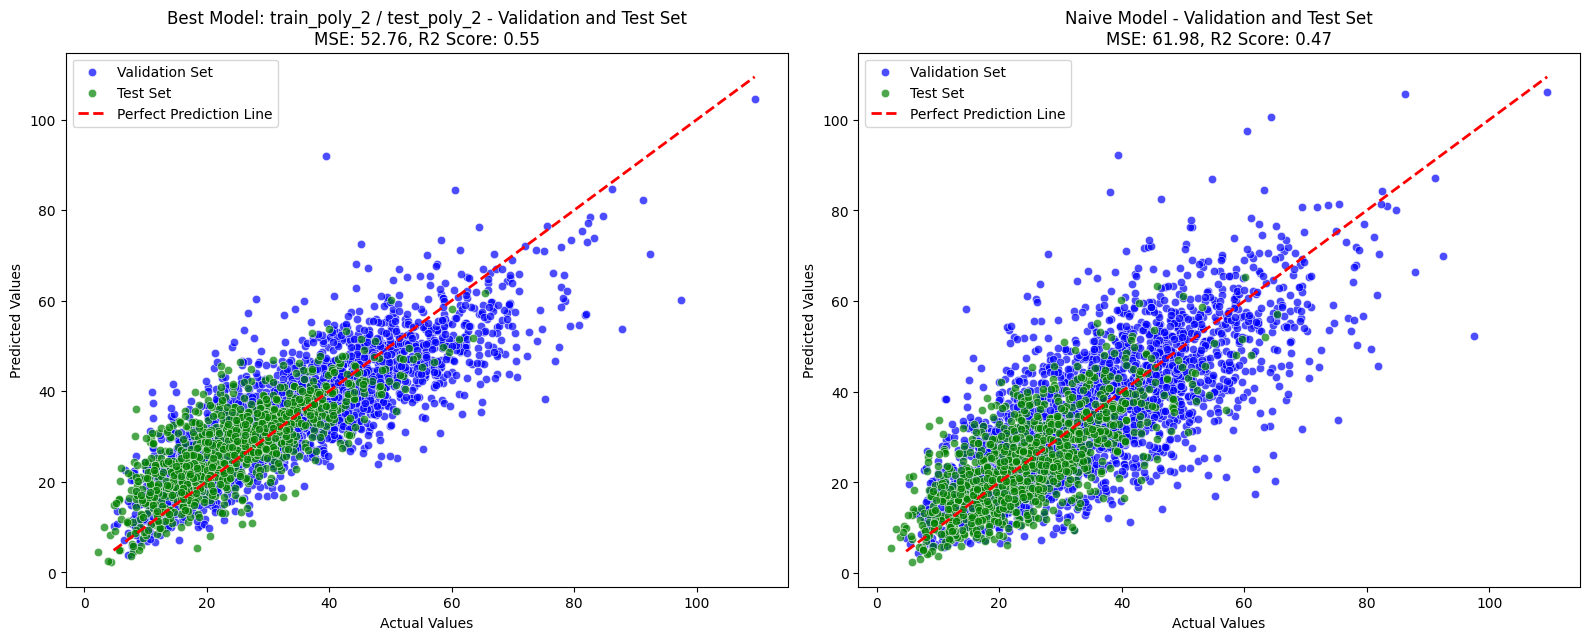

In [95]:
# Display the best model and its scores on the test set
print(f"Best Model Pair on Test Set: {best_model_name}")
print(f"Test MSE: {best_mse}")
print(f"Test R2 Score: {best_r2}")

# Print the MSE for the naive model
print("Naive Model:")
print(f"Test MSE: {mse_test_naive:.2f}")
print(f"Test R2 Score: {r2_test_naive:.2f}")

# Plotting the results for the best model
plt.figure(figsize=(16, 12))

# Subplot for the best model
plt.subplot(2, 2, 1)
sns.scatterplot(x=y_val, y=y_pred_val, color='blue', alpha=0.7, label='Validation Set')
sns.scatterplot(x=y_test, y=y_pred_test, color='green', alpha=0.7, label='Test Set')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], linestyle='--', color='red', linewidth=2, label='Perfect Prediction Line')
plt.title(f"Best Model: {best_model_name} - Validation and Test Set\nMSE: {best_mse:.2f}, R2 Score: {best_r2:.2f}")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()

# Subplot for the naive model
plt.subplot(2, 2, 2)
sns.scatterplot(x=y_val_naive, y=y_pred_val_naive, color='blue', alpha=0.7, label='Validation Set')
sns.scatterplot(x=y_test_naive, y=y_pred_test_naive, color='green', alpha=0.7, label='Test Set')
plt.plot([min(y_val_naive), max(y_val_naive)], [min(y_val_naive), max(y_val_naive)], linestyle='--', color='red', linewidth=2, label='Perfect Prediction Line')
plt.title(f"Naive Model - Validation and Test Set\nMSE: {mse_test_naive:.2f}, R2 Score: {r2_test_naive:.2f}")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()

plt.tight_layout()
plt.show()


### Random Forest

Here it makes no difference whether we use polynomials or not. so we will just use our regular train set

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Dropping non-numeric and irrelevant columns
X_train = train_set.drop(columns=['Datum', 'Street', 'NO2_tomorrow'])
y_train = train_set['NO2_tomorrow']

X_test = test_set.drop(columns=['Datum', 'Street', 'NO2_tomorrow'])
y_test = test_set['NO2_tomorrow']

# Split the training data into training and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Building the Random Forest Regressor with Cross-Validation to optimize hyperparameters
rf = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_split, y_train_split)

# Best parameters
best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_

# Evaluating the optimized model on the validation set
y_pred_val = best_rf.predict(X_val)
mse_val = mean_squared_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

print(f"Train MSE: {mse_val}, Train R2 Score: {r2_val}, Best Parameters: {best_params}")

#evaluate it on our test set
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
print(f"Test Set")
print(f"Test MSE: {mse_test}, Test R2 Score: {r2_test}\n")



Fitting 3 folds for each of 108 candidates, totalling 324 fits
Train MSE: 76.88651213221505, Train R2 Score: 0.6811327257668864, Best Parameters: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Test Set
Test MSE: 55.526644975327024, Test R2 Score: 0.5242633328358104

